# **Shovel Roastery Alyasmin**




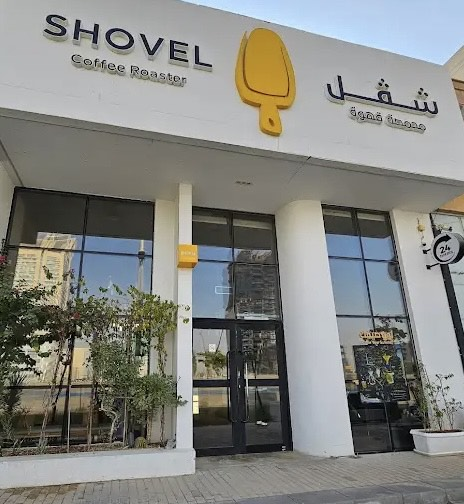

# **Google Maps Reviews Sentiment Analysis Project**

**Place: Shovel Roastery Alyasmin**

In [ ]:
# restart the runtime

import os
os.kill(os.getpid(), 9) # This will restart the runtime in Colab

**Setup: Install Dependencies & Import Libraries**
**Installation**

Install all required packages for the sentiment analysis pipeline:

**Data Processing:** numpy, pandas

**Visualization:** matplotlib, plotly, wordcloud

**NLP:** nltk, camel-tools

**Translation**: langdetect, deep-translator

**Arabic Support:** arabic-reshaper, python-bidi

**ML Models:** transformers (HuggingFace)

In [1]:
# Install Required Libraries

print(" Installing required packages...")
!pip install --quiet --upgrade numpy==1.26.4 pandas matplotlib plotly nltk wordcloud \
    camel-tools langdetect deep-translator tqdm arabic-reshaper python-bidi transformers
print(" Installation complete!")

 Installing required packages...
 Installation complete!


**Import Libraries**
**Purpose**

Import all necessary modules for **data processing**, **visualization**, **NLP**, and **sentiment analysis**.
This section ensures that all dependencies are loaded and configured correctly before starting the analysis pipeline.

In [2]:
# Import All Libraries

import os, json, re, time, urllib.request, warnings
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from wordcloud import WordCloud

# NLP & Text Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Language Tools
from langdetect import detect
from deep_translator import GoogleTranslator

# Arabic Text Support
import arabic_reshaper
from bidi.algorithm import get_display

# Sentiment Analysis
from transformers import pipeline

# Progress Tracking
from tqdm import tqdm
tqdm.pandas()

# INITIAL SETUP
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
warnings.filterwarnings("ignore")

print(" All libraries imported successfully!")

 All libraries imported successfully!


**Download & Setup Arabic Font**

Download **Noto Sans Arabic Bold** font for proper Arabic text rendering in visualizations.

**Font Details:**
- Font: Noto Sans Arabic (Bold)
- Source: Google Fonts GitHub Repository
- Usage: WordCloud, matplotlib titles & labels

**Platform Compatibility:**
- Google Colab
- Linux/Unix
- Windows (with urllib fallback)
- macOS

In [3]:
# Arabic Font Setup

def setup_arabic_font():
    """Download and configure Arabic font for visualizations"""
    FONT_URL = "https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansArabic/NotoSansArabic-Bold.ttf"
    FONT_PATH = os.path.join(os.getcwd(), "NotoSansArabic-Bold.ttf")

    try:
        if not os.path.exists(FONT_PATH):
            urllib.request.urlretrieve(FONT_URL, FONT_PATH)
            print(" Font downloaded successfully")
        else:
            print(" Font already exists")

        if os.path.getsize(FONT_PATH) < 100*1024:
            raise ValueError("Font file too small or corrupted")

        arabic_font = fm.FontProperties(fname=FONT_PATH)
        font_name = arabic_font.get_name()
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
        print(f" Matplotlib configured with Arabic font: {font_name}")
        return FONT_PATH
    except Exception as e:
        print(f" Font setup failed: {e}")
        return None

ARABIC_FONT_PATH = setup_arabic_font()

 Font already exists
 Matplotlib configured with Arabic font: Noto Sans Arabic


**Date Parsing Utilities**

**Parse Relative Arabic Dates**

Convert relative date strings (e.g., "قبل 20 ساعة") to absolute datetime objects.

**Supported Formats:**
- `قبل X ساعة` → X hours ago
- `قبل X يوم` → X days ago  
- `قبل X شهر` → X months ago (≈30 days)
- `قبل X سنة` → X years ago (≈365 days)
- Absolute dates: `YYYY-MM-DD`

**Use Case:**
Google Maps reviews often contain relative timestamps that need conversion to absolute datetime for time-series analysis.


In [4]:
# DATE PARSING UTILITIES

REFERENCE_DATE = datetime.now()

def parse_relative_date(date_str, reference_date=REFERENCE_DATE):
    """
    Convert relative Arabic date strings to absolute datetime objects.
    """
    if pd.isna(date_str) or not isinstance(date_str, str):
        return pd.NaT

    date_str = date_str.strip()
    if not date_str:
        return pd.NaT

    # Absolute date
    try:
        if re.search(r'\d{4}-\d{2}-\d{2}', date_str):
            return pd.to_datetime(date_str, errors='coerce')
    except Exception:
        pass

    # Relative date patterns
    patterns = {
        'ساعة': ('hours', 1), 'ساعات': ('hours', 1),
        'يوم': ('days', 1), 'يومين': ('days', 2), 'أيام': ('days', 1),
        'أسبوع': ('weeks', 1), 'أسابيع': ('weeks', 1),
        'شهر': ('days', 30), 'شهور': ('days', 30),
        'سنة': ('days', 365), 'سنوات': ('days', 365)
    }

    for word, (unit, multiplier) in patterns.items():
        match = re.search(rf'قبل\s+(\d+)\s+{word}', date_str)
        if match:
            value = int(match.group(1))
            delta = timedelta(**{unit: value * multiplier})
            return reference_date - delta

    # Special cases
    specials = {'أمس': 1, 'البارحة': 1, 'اليوم': 0}
    for k, v in specials.items():
        if k in date_str:
            return reference_date - timedelta(days=v)

    return pd.NaT

**Reading and Preparing Raw Data from JSON**

In this section, we:

1. Load the JSON file containing Google Maps reviews.
2. Handle different possible data structures:
   - A list of reviews (`list`)
   - A dictionary with a `"reviews"` key (`dict`)
   - A single record fallback
3. Display a sample of the data and its columns for a quick sanity check.
4. Verify the expected columns (`text`, `textTranslated`, `rating`, `stars ` ) and notify if any are missing.



In [5]:
# READ AND PREPARE RAW DATA

json_file = "Shovel_roastery_yasmin_reviews_raw.json"

# Load JSON file
try:
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f" Loaded {json_file} successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f" File not found: {json_file}")
except json.JSONDecodeError as e:
    raise ValueError(f" Failed to parse JSON file:\n{e}")

# Handle different data structures
if isinstance(data, list):
    df = pd.DataFrame(data)
    print("Detected format: List of reviews ")
elif isinstance(data, dict) and "reviews" in data:
    df = pd.DataFrame(data["reviews"])
    print("Detected format: Dictionary with 'reviews' key ")
else:
    df = pd.DataFrame([data])
    print(" Data format unusual — wrapped single record as DataFrame")

# Summary of data loaded
print(f"\n Loaded {len(df)} reviews into DataFrame.")
print(" Raw Columns:", df.columns.tolist())

# Verify expected columns
expected_cols = ['text', 'textTranslated', 'rating', 'stars']
missing_cols = [c for c in expected_cols if c not in df.columns]

if missing_cols:
    print(f"\n Missing expected columns: {missing_cols}")
else:
    print("\n Expected columns are present.")

# Display a sample of the raw data
print("\n Raw Data Sample:")
display(df.head(10))

 Loaded Shovel_roastery_yasmin_reviews_raw.json successfully.
Detected format: List of reviews 

 Loaded 1693 reviews into DataFrame.
 Raw Columns: ['searchString', 'reviewerId', 'reviewerUrl', 'name', 'reviewerNumberOfReviews', 'isLocalGuide', 'reviewerPhotoUrl', 'text', 'textTranslated', 'publishAt', 'publishedAtDate', 'likesCount', 'reviewId', 'reviewUrl', 'reviewOrigin', 'stars', 'rating', 'responseFromOwnerDate', 'responseFromOwnerText', 'reviewImageUrls', 'reviewContext', 'reviewDetailedRating', 'visitedIn', 'originalLanguage', 'translatedLanguage', 'isAdvertisement', 'placeId', 'location', 'address', 'neighborhood', 'street', 'city', 'postalCode', 'state', 'countryCode', 'categoryName', 'categories', 'title', 'totalScore', 'permanentlyClosed', 'temporarilyClosed', 'reviewsCount', 'url', 'price', 'cid', 'fid', 'imageUrl', 'scrapedAt', 'language']

 Expected columns are present.

 Raw Data Sample:


searchString  \
0  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
1  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
2  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
3  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
4  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
5  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
6  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
7  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
8  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   
9  Direct Detail URL: https://www.google.com/maps/place/Shovel+Roastery/@24.8041882,46.6098404,12z/...   

              reviewerId  \
0  101338619816340874273   
1  114852834559632636036   
2  116632129612755847440   
3  111080740695461174651   
4  101326712736185693428   
5  117253576005281190668   
6  110991972353223844119   
7  111526120300429714283   
8  102645178039492288271   
9  108333792278086184791   

                                                       reviewerUrl  \
0  https://www.google.com/maps/contrib/101338619816340874273?hl=ar   
1  https://www.google.com/maps/contrib/114852834559632636036?hl=ar   
2  https://www.google.com/maps/contrib/116632129612755847440?hl=ar   
3  https://www.google.com/maps/contrib/111080740695461174651?hl=ar   
4  https://www.google.com/maps/contrib/101326712736185693428?hl=ar   
5  https://www.google.com/maps/contrib/117253576005281190668?hl=ar   
6  https://www.google.com/maps/contrib/110991972353223844119?hl=ar   
7  https://www.google.com/maps/contrib/111526120300429714283?hl=ar   
8  https://www.google.com/maps/contrib/102645178039492288271?hl=ar   
9  https://www.google.com/maps/contrib/108333792278086184791?hl=ar   

               name  reviewerNumberOfReviews  isLocalGuide  \
0              Roox                        6         False   
1        y. الشراري                        1         False   
2   Md Shorif Hosen                        0         False   
3            Foodie                       79          True   
4      Abeer Khalid                        9         False   
5          ابو سعود                       90          True   
6  ibtihaj Mohammed                       14         False   
7    SALEH ABDULLAH                       79          True   
8             Nf nf                        4         False   
9     خالد القحطاني                       39          True   

                                                                                      reviewerPhotoUrl  \
0  https://lh3.googleusercontent.com/a-/ALV-UjVAPGu0LGLOO08dQNX84xwAY1_2QF_led77Lyvd5Ex008_-45M=s19...   
1  https://lh3.googleusercontent.com/a/ACg8ocJTCWy-3kGJucUM4b7HTuR_VEHz0zy1nxH3EyDz_pbYJVd2Mg=s1920...   
2  https://lh3.googleusercontent.com/a-/ALV-UjX8Q8oOrc7lKdnGJH4fJv7JI_lFoQM5ar0-LLGP6HzTCVDrKgMBZw=...   
3  https://lh3.googleusercontent.com/a-/ALV-UjXGLXfVmnmDQ1is5UQ0GGKsgD4SEbHqKqjk_rgqeWrrnRcBVY_-=s1...   
4  https://lh3.googleusercontent.com/a/ACg8ocKocXVMXZte7oMHiLCuxLttc7fC4rlv8PfqsC9c6fzhxfVmOg=s1920...   
5  https://lh3.googleusercontent.com/a-/ALV-UjUaBkZSy-7d-hW-liOWAoTaOjfMBOQMkD5gCJwtBz4TboHVl_M=s19...   
6  https://lh3.googleusercontent.com/a/ACg8ocLXaLqMEGU8ddg10TFcLs2cGLMWtbYcJYP__DEC_wG78FCbguE=s192...   
7  https://lh3.googleusercontent.com/a-/ALV-UjVzmbPvC-WBW7yHthYP3EdLpkKN2jvwj37VgpSxo7Jtck9oEWg=s19...   
8  https://lh3.googleusercontent.com/a/ACg8ocLTw7S_lbFGIsRBRyXJal7JqsPjWnWL6cmekOPcPQGTfhgc9Q=s1920...   
9  https://lh3.googleusercontent.com/a/ACg8ocJGZ-KBX0udPfwHu5SlAi2sV__7d56KHIrDi-8OqLv4SVUgNA=s1920.

**Clean and Prepare Data**

In this step, we:

1. **Select Key Columns**  
   Define the main columns to keep for analysis: `name`, `stars`, `textTranslated`, `text`, `publishAt`, `publishedAtDate`.

2. **Ensure Column Existence**  
   Create missing columns if they are not present in the raw DataFrame to avoid errors during processing.

3. **Pre-process Dates**  
   - Convert relative Arabic dates (e.g., "قبل 3 يوم") into absolute datetime objects using the `parse_relative_date` function.
   - Combine absolute dates (`publishedAtDate`) with processed relative dates.

4. **Create Clean DataFrame**  
   - `Author Name`: From `name` column  
   - `Rating`: Numeric conversion of `stars`  
   - `Review Text`: Prefer translated text (`textTranslated`), fallback to original text (`text`)  
   - `Review Date`: Combined absolute and relative dates

5. **Filter and Classify Ratings**  
   - Keep ratings between 1 and 5  
   - Create a rating-based sentiment label:  
     - 1–2 → Negative  
     - 3 → Neutral  
     - 4–5 → Positive

6. **Save Cleaned Dataset**  
   - Output to CSV for further analysis  
   - Preview the first 10 rows



In [6]:
# CLEAN AND PREPARE DATA

print("\n Starting data cleaning and preparation...")

# Ensure key columns exist
columns_to_keep = ["name", "stars", "rating", "textTranslated", "text", "publishAt", "publishedAtDate"]
for col in columns_to_keep:
    if col not in df.columns:
        df[col] = None

# Handle missing or malformed date strings
df["publishAt"] = df["publishAt"].astype(str).replace(["None", "nan", "NaT"], np.nan)

# Process relative and absolute dates safely
processed_relative_dates = df["publishAt"].apply(parse_relative_date)
processed_absolute_dates = pd.to_datetime(df["publishedAtDate"], errors="coerce")

# Create unified cleaned DataFrame
rating_source = "stars" if "stars" in df.columns else "rating"

df_clean = pd.DataFrame({
    "Author Name": df.get("name"),
    "Rating": pd.to_numeric(df.get(rating_source), errors="coerce"),
    "Review Text": df["textTranslated"].combine_first(df["text"]),
    "Review Date": processed_absolute_dates.combine_first(processed_relative_dates)
})

# Drop missing essential info
initial_count = len(df_clean)
df_clean.dropna(subset=["Review Text", "Rating"], inplace=True)
dropped_count = initial_count - len(df_clean)

if dropped_count > 0:
    print(f" Dropped {dropped_count} rows missing text or rating.")

# Filter valid ratings (1–5 only)
df_clean = df_clean[df_clean["Rating"].between(1, 5)].reset_index(drop=True)

# Classify sentiment based on rating
def classify_sentiment(r):
    if r <= 2:
        return "Negative"
    elif r == 3:
        return "Neutral"
    return "Positive"

df_clean["Sentiment (Rating-Based)"] = df_clean["Rating"].apply(classify_sentiment)

# Save cleaned dataset
os.makedirs("outputs", exist_ok=True)
clean_path = "outputs/Shovel_roastery_yasmin_reviews_clean_full.csv"
df_clean.to_csv(clean_path, index=False, encoding="utf-8-sig")

# Summary
print(f"\n Clean data saved to: {clean_path}")
print(f" Final dataset contains {len(df_clean)} valid reviews.")
print("\n Sentiment distribution:")
print(df_clean["Sentiment (Rating-Based)"].value_counts())

# Preview sample
print("\n Sample of cleaned data:")
display(df_clean.head(10))


 Starting data cleaning and preparation...
 Dropped 376 rows missing text or rating.

 Clean data saved to: outputs/Shovel_roastery_yasmin_reviews_clean_full.csv
 Final dataset contains 1317 valid reviews.

 Sentiment distribution:
Sentiment (Rating-Based)
Positive    1111
Negative     128
Neutral       78
Name: count, dtype: int64

 Sample of cleaned data:


Author Name  Rating  \
0         y. الشراري       5   
1             Foodie       5   
2       Abeer Khalid       5   
3   ibtihaj Mohammed       5   
4     SALEH ABDULLAH       5   
5      خالد القحطاني       2   
6    Md Akidul Islam       5   
7          خالد احمد       5   
8  عبدالعزيز الغامدي       5   
9            Sumaiya       5   

                                                                                           Review Text  \
0          القهوة لذيذة جدا والمكان رايق، وتعامل الموظفين أكثر من رائع خاصه عبدالحكيم يستحق الزيارة🤍👍🏻   
1  One of the best pour over cafes in Riyadh. Well balanced and rich iced pour over. Try their coco...   
2  الأجواء في شفل جداً راقية وهادئة، بصراحة انبهرت بالتجربة من أول لحظة دخلت فيها. محمصة وكوفي جميل...   
3  مكاني المفضل كل يوم ، الباريستا محمود متعاون جداً ويساعد ومهتم للخدمه ويقدمها لشكل فوق الممتاز.....   
4                                                                                    المكان جميل ورايق   
5  الكوفي سيء من ناحيه الخدمة والتعامل وغير كذا طلبت من عندهم قهوة مقطرة محصول فاخر وكان الكاشير يق...   
6                                                                                           لطيف - جيد   
7                                        اشكر الاخ الموجود على الكاشير اسلوب وتعامل راقي جدا ربي يسعدك   
8                                                                  اليوم القهوه مجاناً مع مصرف الراجحي   
9                                                                                                  100   

                       Review Date Sentiment (Rating-Based)  
0 2025-10-17 07:21:24.708000+00:00                 Positive  
1 2025-10-15 13:58:58.361000+00:00                 Positive  
2 2025-10-14 13:05:19.070000+00:00                 Positive  
3 2025-10-13 21:54:50.829000+00:00                 Positive  
4 2025-10-13 17:03:13.240000+00:00                 Positive  
5 2025-10-11 10:10:05.784000+00:00                 Negative  
6 2025-10-09 14:29:40.888000+00:00                 Positive  
7 2025-10-09 10:17:23.681000+00:00                 Positive  
8 2025-10-09 08:29:02.195000+00:00                 Positive  
9 2025-10-06 21:21:10.544000+00:00                 Positive

**Data Validation**
**Overview**

This function validates the cleaned dataset and reports any data quality issues, including:

**Future Dates** – Reviews with dates later than today.

**Invalid Ratings** – Ratings outside the 1–5 range.

**Empty or Missing Review Text** – Reviews with no text.

**Duplicate Reviews** – Multiple reviews with identical text.

In [7]:
# DATA VALIDATION

def validate_data(df):
    """ Validate data quality and print detailed issues report"""
    issues = []
    now = pd.Timestamp(datetime.now()).tz_localize(None)

    print("\n Starting data quality validation...\n")

    # Check for future dates
    if "Review Date" in df.columns:
        df_dates = df.dropna(subset=["Review Date"]).copy()
        df_dates["Review Date"] = pd.to_datetime(df_dates["Review Date"], errors='coerce')

        # Remove timezone info if present
        if df_dates["Review Date"].dt.tz is not None:
            df_dates["Review Date"] = df_dates["Review Date"].dt.tz_localize(None)

        future_dates = df_dates[df_dates["Review Date"] > now]
        if len(future_dates) > 0:
            issues.append(f" {len(future_dates)} تواريخ مستقبلية (يُفضّل مراجعتها)")

    # Check for invalid ratings
    if "Rating" in df.columns:
        invalid_ratings = df[~df["Rating"].between(1, 5)]
        if len(invalid_ratings) > 0:
            issues.append(f" {len(invalid_ratings)} تقييمات خارج النطاق (1-5)")

    # Check for empty or missing review text
    if "Review Text" in df.columns:
        empty_text = df[df["Review Text"].isna() | (df["Review Text"].astype(str).str.strip() == "")]
        if len(empty_text) > 0:
            issues.append(f" {len(empty_text)} نصوص مراجعات فارغة")

    # Check for duplicate review texts
    if "Review Text" in df.columns:
        duplicates = df[df.duplicated(subset=["Review Text"], keep=False)]
        if len(duplicates) > 0:
            issues.append(f" {len(duplicates)} مراجعات مكرّرة")

    # Print results
    if issues:
        print(" تحذيرات جودة البيانات:\n")
        for issue in issues:
            print("-", issue)
    else:
        print(" جميع البيانات صالحة — لا توجد مشاكل في الجودة.")

    return issues


# Run validation
print("\n Running data validation...")
validation_issues = validate_data(df_clean)


 Running data validation...

 Starting data quality validation...

 تحذيرات جودة البيانات:

-  16 مراجعات مكرّرة


**Duplicate Review Check**
This section flags duplicate reviews in the dataset.  
It distinguishes between:
1. **Duplicate text across all authors** (`is_duplicate_text`)  
2. **Duplicate text from the same author** (`duplicate_same_author`)  

This helps to understand that repeated reviews may exist but are written by different people, so they don't need to be removed.


In [8]:
# Flag duplicates based on Review Text only
df_clean['is_duplicate_text'] = df_clean.duplicated(subset=['Review Text'], keep=False)

# Find duplicates for the same author
df_clean['duplicate_same_author'] = df_clean.duplicated(subset=['Author Name', 'Review Text'], keep='first')

# Number of duplicates by same author
same_author_dupes = df_clean['duplicate_same_author'].sum()
print(f"Number of duplicates from same author: {same_author_dupes}")

Number of duplicates from same author: 0


**Language Detection & Translation**

In this critical step, we prepare the reviews for Arabic-centric sentiment analysis by ensuring all relevant text is in Arabic and handling potential translation issues.

1.  **Detect Review Language**
    * We use the **`langdetect`** library to identify the primary language of each review.
    * Reviews with empty text are safely marked as **`"unknown"`**.

2.  **Translate English Reviews to Arabic**
    * A robust function is defined using **`deep-translator`** to perform **English → Arabic** translation.
    * Translation is strictly conditional: **only reviews detected as English (`lang == "en"`) are processed**.

3.  **Ensure Robustness & Track Progress**
    * The translation function now includes **exception handling** to log any texts that fail the API call (e.g., due to network issues or rate limits). The original text is kept in case of failure.
    * We utilize **`pandas.progress_apply`** to monitor the progress of this time-consuming step.

4.  **Save & Preview Translated Dataset**
    * The `df_clean` DataFrame is updated with the new `Review Text AR` column and saved to a new CSV file for persistence.
    * A preview shows the original text, the Arabic translation, and the detected language.

In [9]:
# LANGUAGE DETECTION & TRANSLATION

FAILED_TRANSLATIONS = []

def detect_lang(text):
    """Safely detect language of text"""
    if not text or str(text).strip() == "":
        return "unknown"
    try:
        return detect(text)
    except:
        return "unknown"

df_clean["Language"] = df_clean["Review Text"].apply(detect_lang)

def translate_to_arabic(text, lang, max_retries=3):
    """
    Translate English text to Arabic with retry mechanism.

    Args:
        text: Text to translate
        lang: Detected language
        max_retries: Number of retry attempts for failed translations
    """
    if isinstance(text, str) and lang == "en":
        for attempt in range(max_retries):
            try:
                translated = GoogleTranslator(source="en", target="ar").translate(text)
                return translated
            except Exception as e:
                if attempt < max_retries - 1:
                    wait_time = 2 ** attempt
                    print(f" Translation attempt {attempt + 1} failed, retrying in {wait_time}s...")
                    time.sleep(wait_time)
                    continue
                print(f" Translation failed after {max_retries} attempts: {text[:50]}...")
                FAILED_TRANSLATIONS.append({"text": text, "error": str(e)})
                return text
    return text

print("\n Translating English reviews to Arabic...")

# OPTIMIZATION: Only translate English reviews
mask_english = df_clean["Language"] == "en"
english_count = mask_english.sum()

if english_count > 0:
    print(f" Found {english_count} English reviews to translate...")
    df_clean.loc[mask_english, "Review Text AR"] = df_clean.loc[mask_english].progress_apply(
        lambda x: translate_to_arabic(x["Review Text"], x["Language"]), axis=1
    )
    # Copy Arabic reviews as-is
    df_clean.loc[~mask_english, "Review Text AR"] = df_clean.loc[~mask_english, "Review Text"]
else:
    print(" No English reviews found, copying original text...")
    df_clean["Review Text AR"] = df_clean["Review Text"]

translated_path = "outputs/Shovel_roastery_yasmin_reviews_translated.csv"
df_clean.to_csv(translated_path, index=False, encoding="utf-8-sig")

print(f"\n Translated data saved to: {translated_path}")
print(f" Total translation failures: {len(FAILED_TRANSLATIONS)}")
if FAILED_TRANSLATIONS:
    print(f" Failed translations saved for review")

display(df_clean[["Review Text", "Review Text AR", "Language"]].head(10))


 Translating English reviews to Arabic...
 Found 6 English reviews to translate...


100%|██████████| 6/6 [00:00<00:00, 11.22it/s]



 Translated data saved to: outputs/Shovel_roastery_yasmin_reviews_translated.csv
 Total translation failures: 0


Review Text  \
0          القهوة لذيذة جدا والمكان رايق، وتعامل الموظفين أكثر من رائع خاصه عبدالحكيم يستحق الزيارة🤍👍🏻   
1  One of the best pour over cafes in Riyadh. Well balanced and rich iced pour over. Try their coco...   
2  الأجواء في شفل جداً راقية وهادئة، بصراحة انبهرت بالتجربة من أول لحظة دخلت فيها. محمصة وكوفي جميل...   
3  مكاني المفضل كل يوم ، الباريستا محمود متعاون جداً ويساعد ومهتم للخدمه ويقدمها لشكل فوق الممتاز.....   
4                                                                                    المكان جميل ورايق   
5  الكوفي سيء من ناحيه الخدمة والتعامل وغير كذا طلبت من عندهم قهوة مقطرة محصول فاخر وكان الكاشير يق...   
6                                                                                           لطيف - جيد   
7                                        اشكر الاخ الموجود على الكاشير اسلوب وتعامل راقي جدا ربي يسعدك   
8                                                                  اليوم القهوه مجاناً مع مصرف الراجحي   
9                                                                                                  100   

                                                                                        Review Text AR  \
0          القهوة لذيذة جدا والمكان رايق، وتعامل الموظفين أكثر من رائع خاصه عبدالحكيم يستحق الزيارة🤍👍🏻   
1  من أفضل المقاهي في الرياض. صب المثلج المتوازن والغني. جرب الفول بنكهة جوز الهند 10/10! فريق عمل ...   
2  الأجواء في شفل جداً راقية وهادئة، بصراحة انبهرت بالتجربة من أول لحظة دخلت فيها. محمصة وكوفي جميل...   
3  مكاني المفضل كل يوم ، الباريستا محمود متعاون جداً ويساعد ومهتم للخدمه ويقدمها لشكل فوق الممتاز.....   
4                                                                                    المكان جميل ورايق   
5  الكوفي سيء من ناحيه الخدمة والتعامل وغير كذا طلبت من عندهم قهوة مقطرة محصول فاخر وكان الكاشير يق...   
6                                                                                           لطيف - جيد   
7                                        اشكر الاخ الموجود على الكاشير اسلوب وتعامل راقي جدا ربي يسعدك   
8                                                                  اليوم القهوه مجاناً مع مصرف الراجحي   
9                                                                                                  100   

  Language  
0       ar  
1       en  
2       ar  
3       ar  
4       ar  
5       ar  
6       ar  
7       ar  
8       ar  
9  unknown

**Arabic Sentiment Analysis (Hybrid: CAMeL + Rating-Based)**

This section performs **hybrid sentiment analysis** on Arabic reviews by combining CAMeL model predictions with a **rating-based fallback**. This approach improves the accuracy for negative and neutral sentiment classification.

1.** Models Used**

- **CAMeL-Lab BERT**: Context-aware, dialect-sensitive sentiment analysis for Arabic text.
- **Rating-Based Fallback**: Uses the numeric rating of the review to classify sentiment if CAMeL fails or predicts neutral.

2. **Hybrid Approach**

- If CAMeL predicts **positive** or **negative**, its result is used.
- If CAMeL predicts **neutral** or fails → fallback to **rating-based sentiment** (`Rating-Based` column).

3. **Data Preparation**

- Only **non-empty Arabic reviews** are considered.
- Results are stored in `df_clean["Sentiment"]` in **lowercase** format.

4. **Visualization**

- Sentiment counts are plotted as a **bar chart**.
- Arabic labels are reshaped for proper display using `arabic_reshaper` and `bidi.algorithm.get_display`.
- Counts are annotated above each bar.
- Percentages of each sentiment are printed below the chart.

5. **Notes**

- Ensure an **Arabic-supporting font** is properly configured when displaying Arabic text.
- Reviews with **unknown or empty content** are excluded from analysis and visualization.




 Running Hybrid Sentiment Analysis (CAMeL + Rating-Based Fallback)...


100%|██████████| 1317/1317 [00:00<00:00, 463064.66it/s]


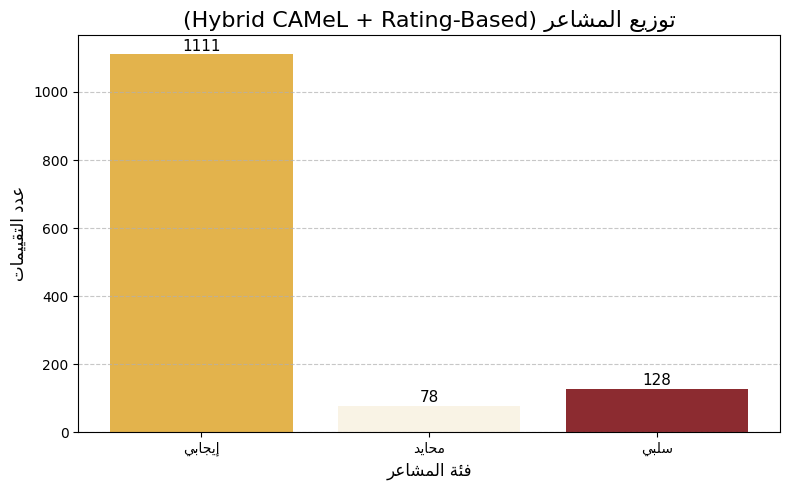


Sentiment Distribution (%):
إيجابي: 84.4%
محايد: 5.9%
سلبي: 9.7%

Total reviews analyzed: 1317


In [10]:
# Arabic Sentiment Analysis (Hybrid CAMeL + Rating-Based)

# Ensure Sentiment column exists
if "Sentiment" not in df_clean.columns:
    df_clean["Sentiment"] = None

# Filter non-empty Arabic reviews
mask_nonempty = df_clean["Review Text AR"].notna() & (df_clean["Review Text AR"].str.strip() != "")
df_analyze = df_clean.loc[mask_nonempty].copy()

# Function to normalize CAMeL labels
def normalize_label(label):
    label = label.lower()
    if "positive" in label:
        return "positive"
    elif "negative" in label:
        return "negative"
    elif "neutral" in label:
        return "neutral"
    else:
        return "neutral"

# Get CAMeL sentiment
def get_sentiment_camel(text):
    text = text[:512]  # Truncate to BERT limit
    try:
        result = camel_model(text)[0]
        return normalize_label(result['label'])
    except:
        return None

print("\n Running Hybrid Sentiment Analysis (CAMeL + Rating-Based Fallback)...")

# Apply CAMeL
df_analyze["Sentiment_CAMeL"] = df_analyze["Review Text AR"].progress_apply(get_sentiment_camel)

# Apply hybrid logic: fallback to Rating-Based if CAMeL fails or gives neutral
def hybrid_sentiment(row):
    if row["Sentiment_CAMeL"] in ["positive", "negative"]:
        return row["Sentiment_CAMeL"]
    else:
        # Fallback to Rating-Based sentiment
        return row["Sentiment (Rating-Based)"].lower()

df_analyze["Sentiment_Hybrid"] = df_analyze.apply(hybrid_sentiment, axis=1)

# Update main DataFrame
df_clean.loc[mask_nonempty, "Sentiment"] = df_analyze["Sentiment_Hybrid"]

# Validation and distribution
sentiment_order = ["positive", "neutral", "negative"]
arabic_labels = {"positive":"إيجابي", "neutral":"محايد", "negative":"سلبي"}

sentiment_counts = df_clean["Sentiment"].value_counts().reindex(sentiment_order, fill_value=0)

# Plot
def fix_arabic_text(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

plt.figure(figsize=(8,5))
colors = {"positive":"#E3B34C", "neutral":"#F9F3E5", "negative":"#8C2B30"}

bars = plt.bar(
    [fix_arabic_text(arabic_labels[s]) for s in sentiment_counts.index],
    sentiment_counts.values,
    color=[colors[s] for s in sentiment_counts.index]
)

plt.title(fix_arabic_text("توزيع المشاعر (Hybrid CAMeL + Rating-Based)"), fontsize=16)
plt.xlabel(fix_arabic_text("فئة المشاعر"), fontsize=12)
plt.ylabel(fix_arabic_text("عدد التقييمات"), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, count in zip(bars, sentiment_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(count),
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("outputs/sentiment_hybrid_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Print percentages
print("\nSentiment Distribution (%):")
percent = (sentiment_counts / sentiment_counts.sum() * 100).round(1)
for s in sentiment_order:
    print(f"{arabic_labels[s]}: {percent[s]}%")

print("\nTotal reviews analyzed:", sentiment_counts.sum())

**Arabic WordCloud & N-Grams Analysis**

This section processes Arabic reviews for WordCloud visualization and n-grams analysis. It includes improvements for Arabic text normalization, stopwords removal, and proper RTL display.

1. **Font Setup**
- Automatically downloads **Noto Sans Arabic** if not present.
- Configures **Matplotlib** to use the Arabic font for correct WordCloud rendering.
- Essential for Colab or headless environments.

2. **Data Cleaning**
- Removes URLs, punctuation, extra spaces, and diacritics.
- Normalizes Arabic letters (`إأآا -> ا`, `ى -> ي`, `ة -> ه`, etc.).
- Handles elongation (`آآه -> آه`) and other noisy characters.
- Applies standard Arabic stopwords removal.

3. **N-Grams Extraction**
- Function `get_ngrams(texts, n)` generates unigrams, bigrams, or trigrams.
- Filters out stopwords and single-character tokens.
- Returns a `Counter` of frequency counts.

4. **Visualization Helpers**
- **Sentiment colors** are defined for positive, negative, and neutral.
- **Gradient color function** applies a color gradient to WordClouds.

5. **Plotting Functions**
- `generate_wordcloud(tokens, title, sentiment)`:
  - Creates a WordCloud from token frequencies.
  - Uses Arabic reshaping and RTL correction for titles.
- `plot_top_ngrams(counter, title, sentiment, top=15)`:
  - Plots the top `n` n-grams in a horizontal bar chart.
  - Applies Arabic reshaping and RTL correction to labels and title.

6. **Execution Example**
- Iterates through each sentiment (`positive`, `negative`, `neutral`).
- Cleans the text column using the enhanced cleaning function.
- Generates:
  - **WordClouds** for unigrams, bigrams, trigrams.
  - **Top n-grams bar plots**.
- Saves outputs to `outputs/` folder if needed.


 Setting up Arabic font for visualizations...
 Arabic font ready for WordClouds.
 Matplotlib configured with font: Noto Sans Arabic

 Applying enhanced Arabic text cleaning and normalization...


100%|██████████| 1317/1317 [00:00<00:00, 28314.91it/s]


 Generating WordClouds and N-grams analysis...

 Processing POSITIVE reviews (1111 texts)
   Generating unigrams...


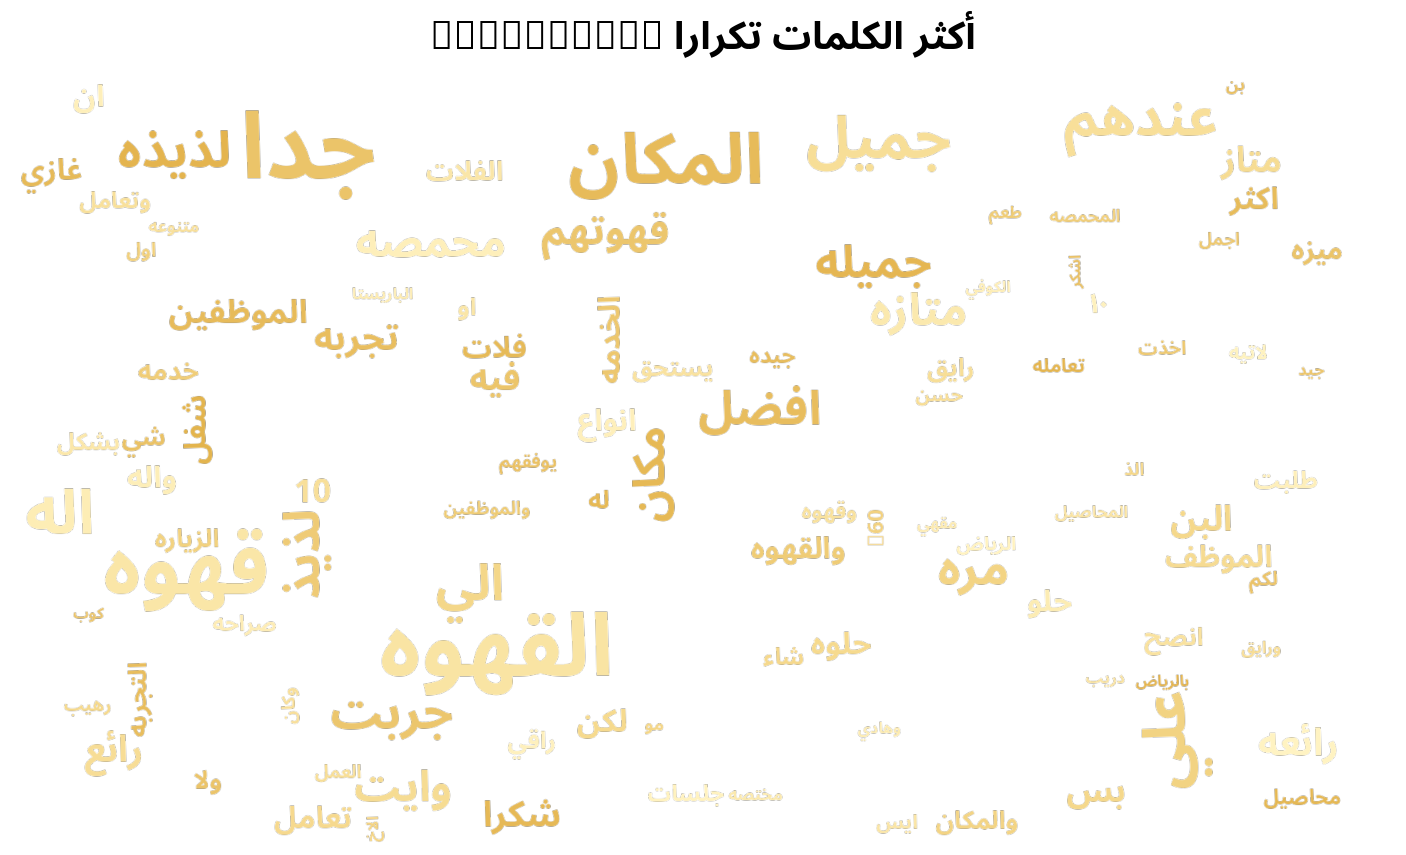

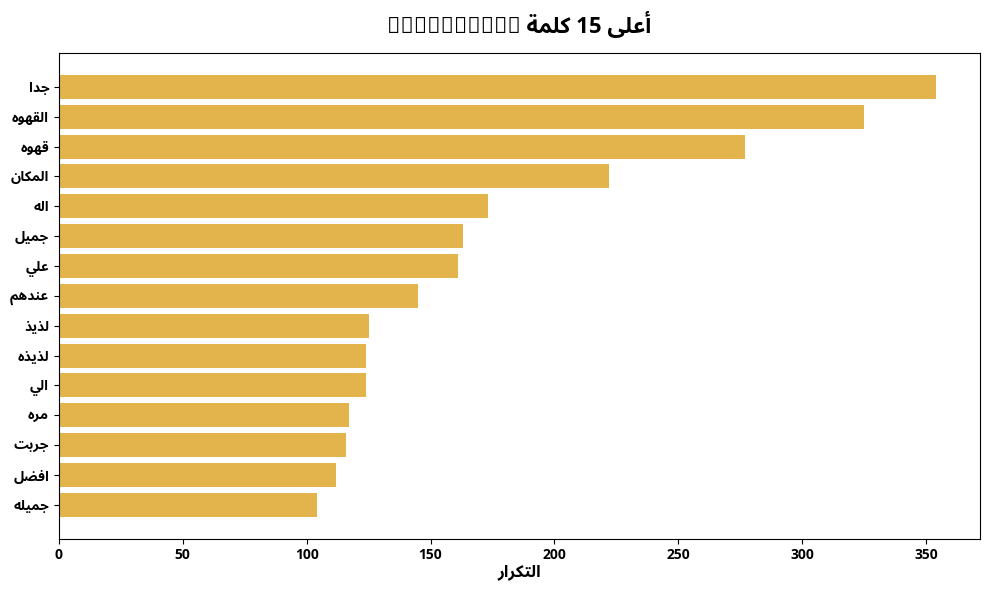

   Generating bigrams...


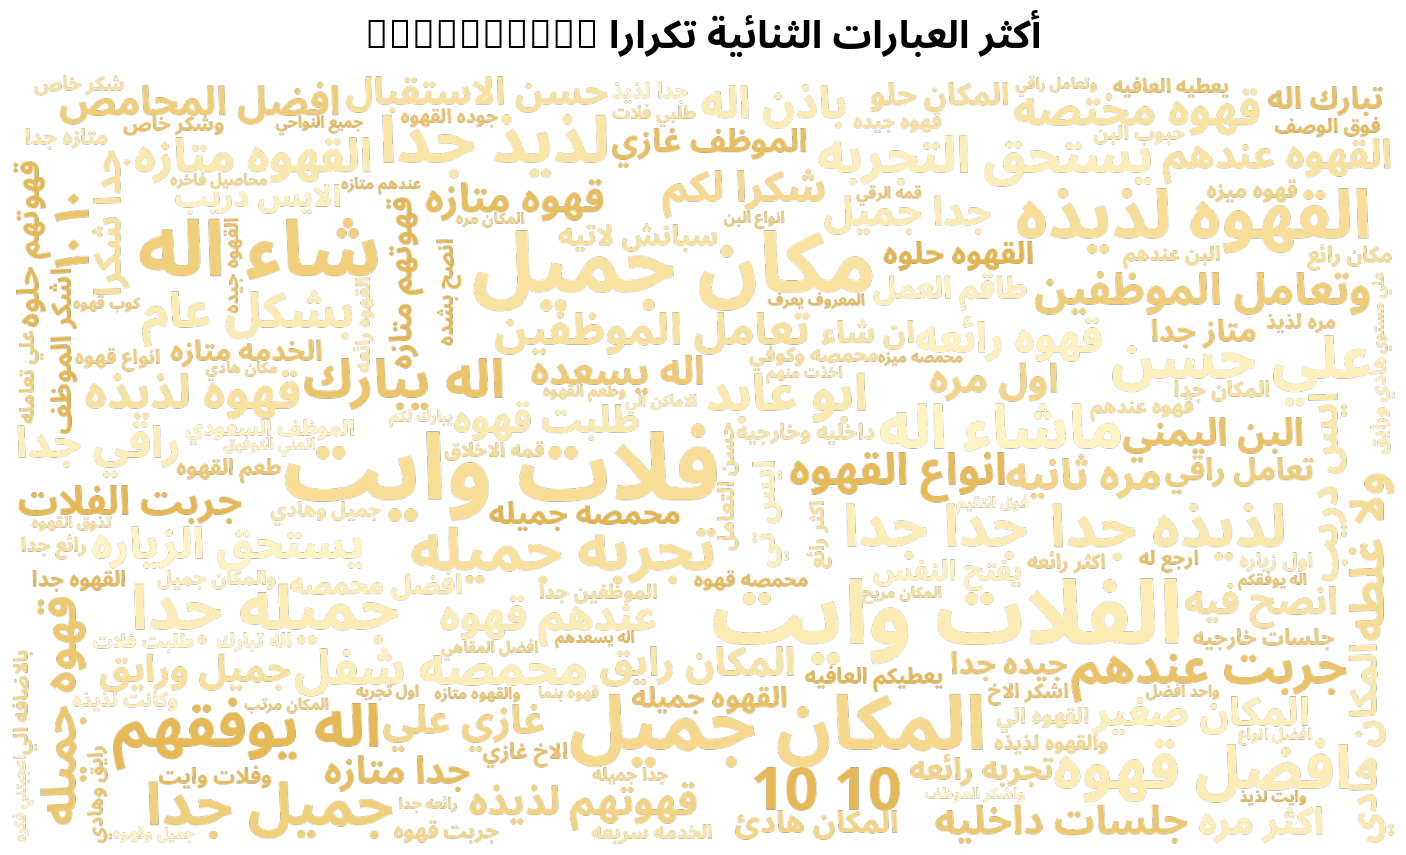

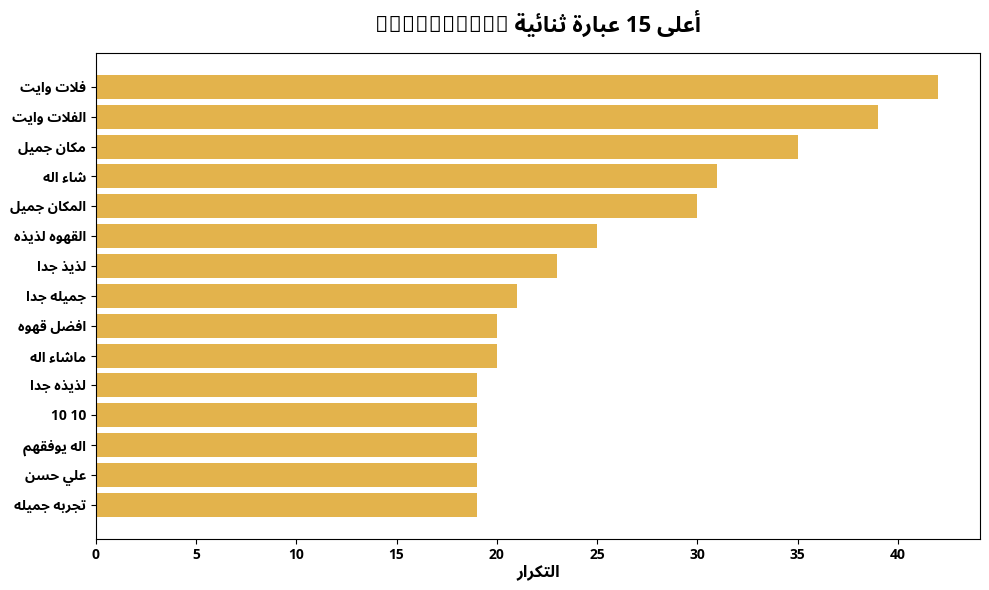

   Generating trigrams...


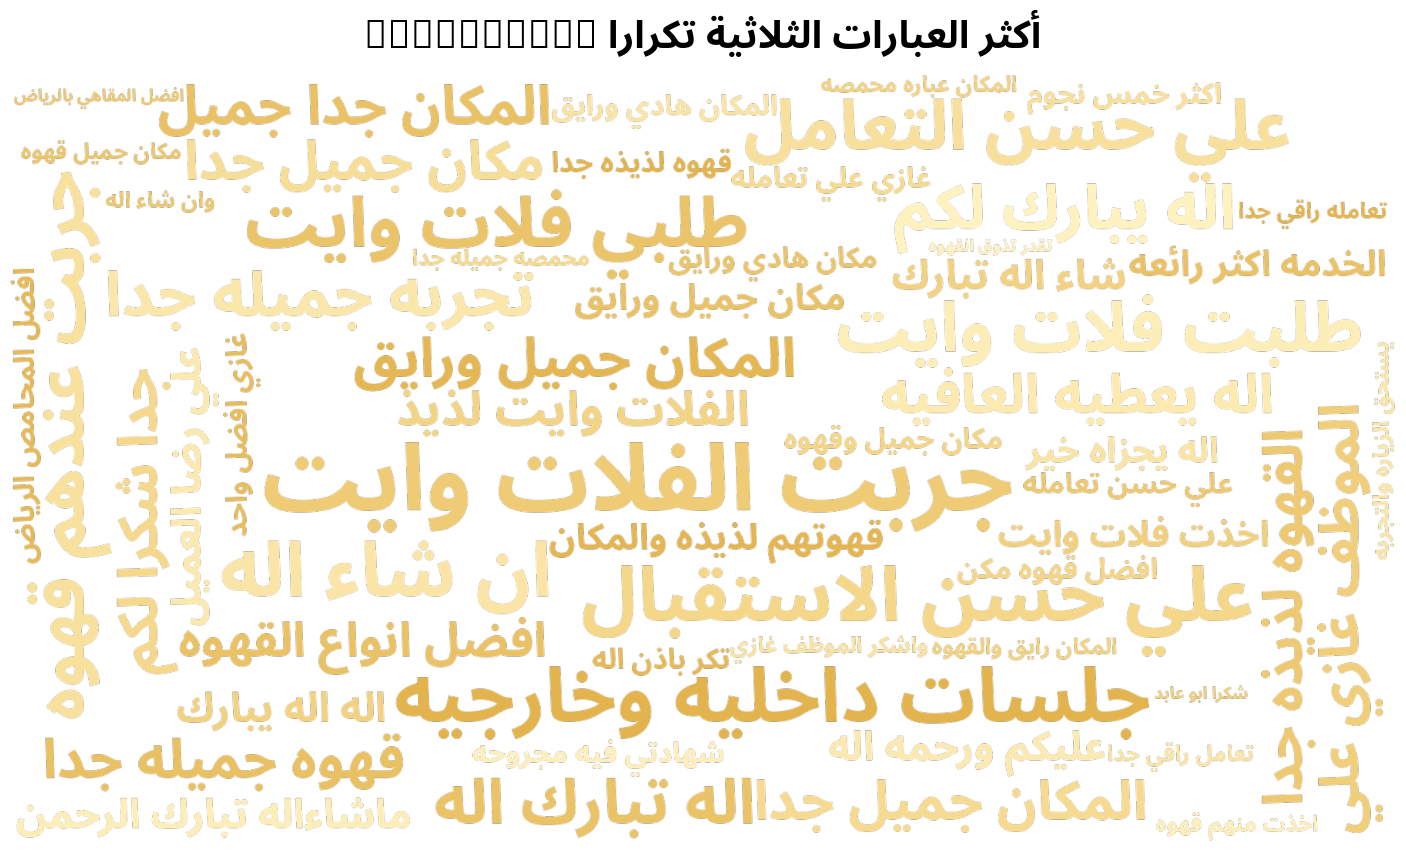

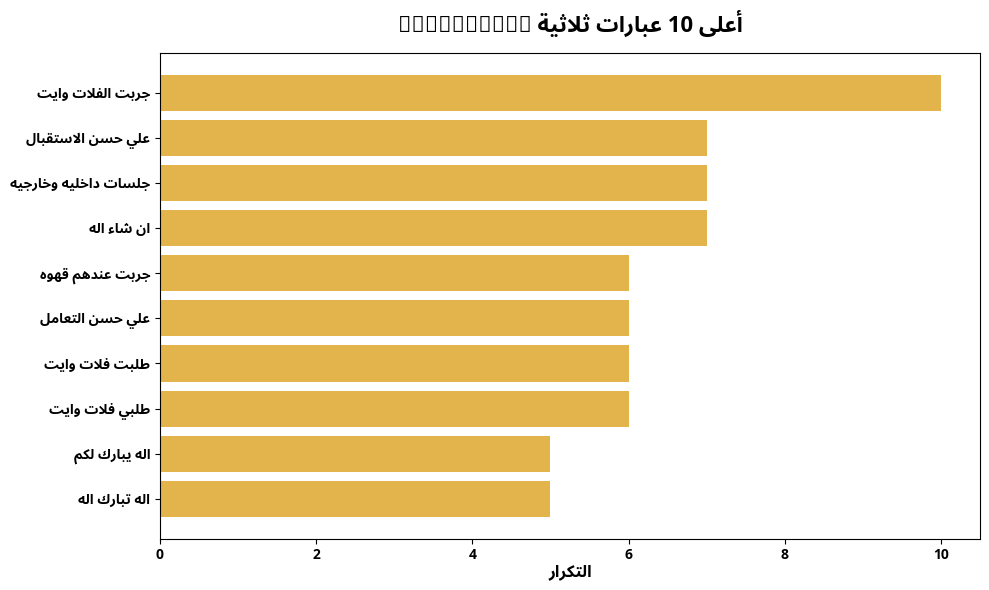


 Processing NEGATIVE reviews (128 texts)
   Generating unigrams...


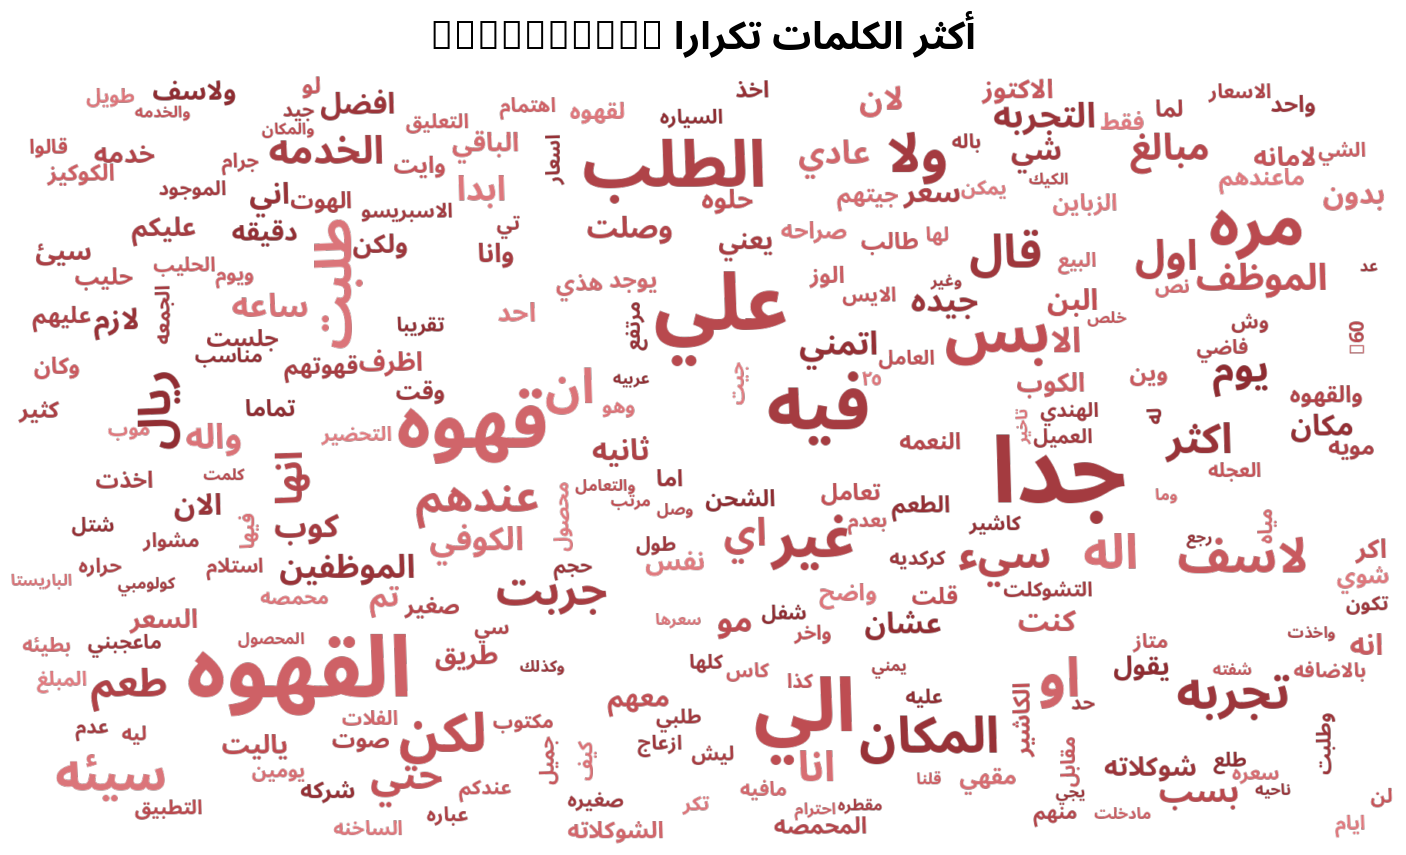

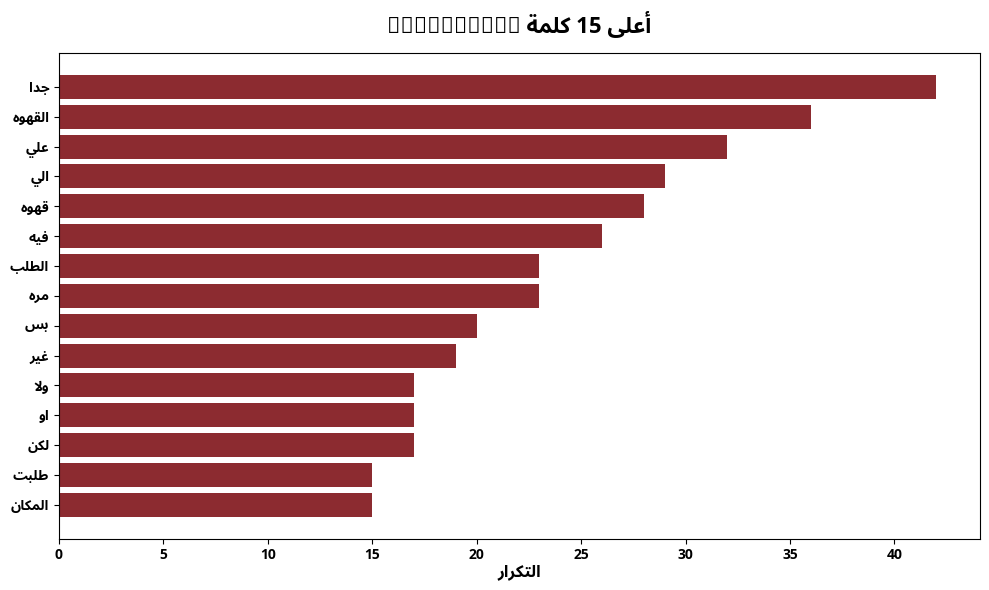

   Generating bigrams...


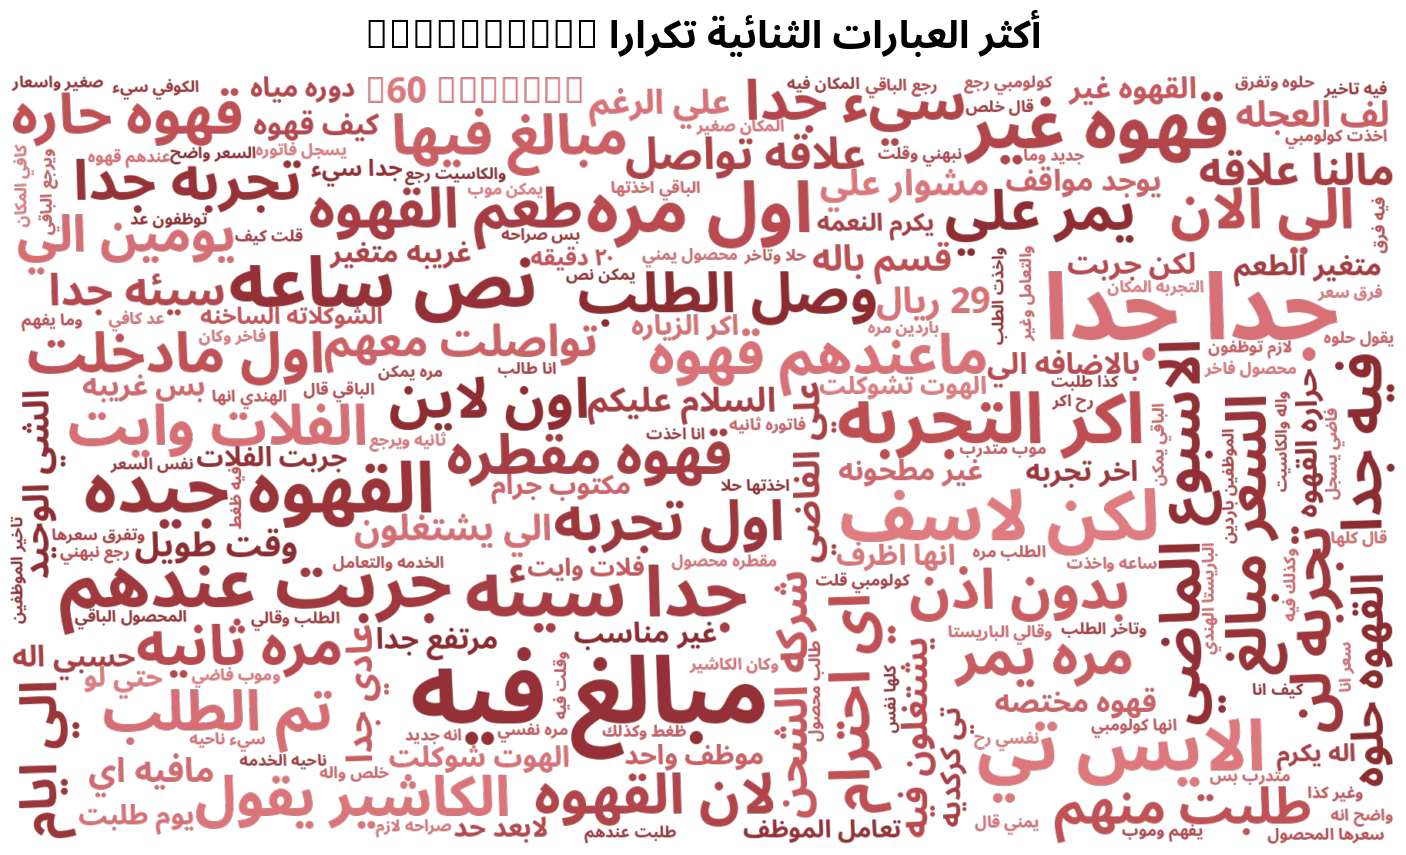

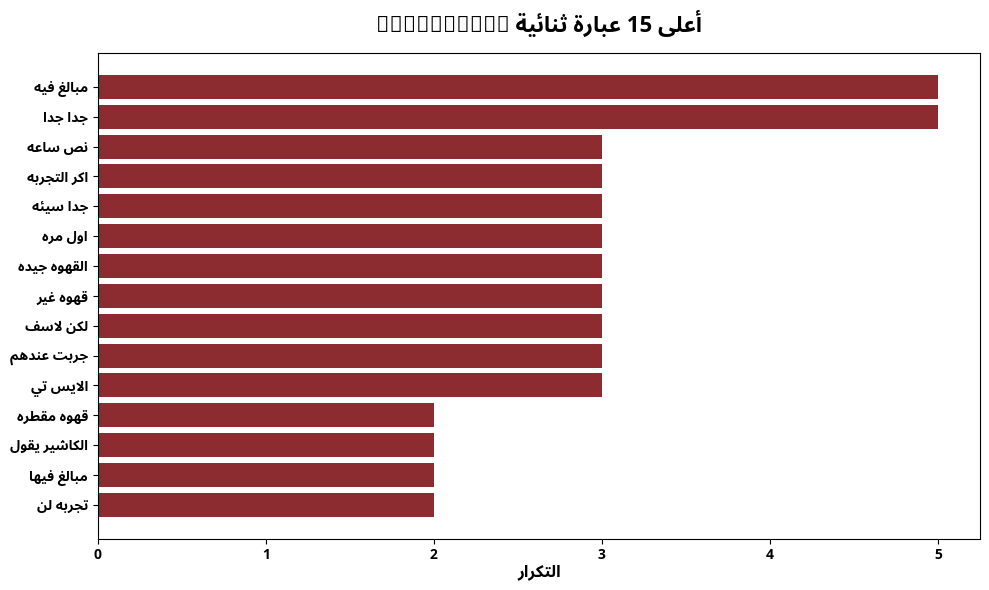

   Generating trigrams...


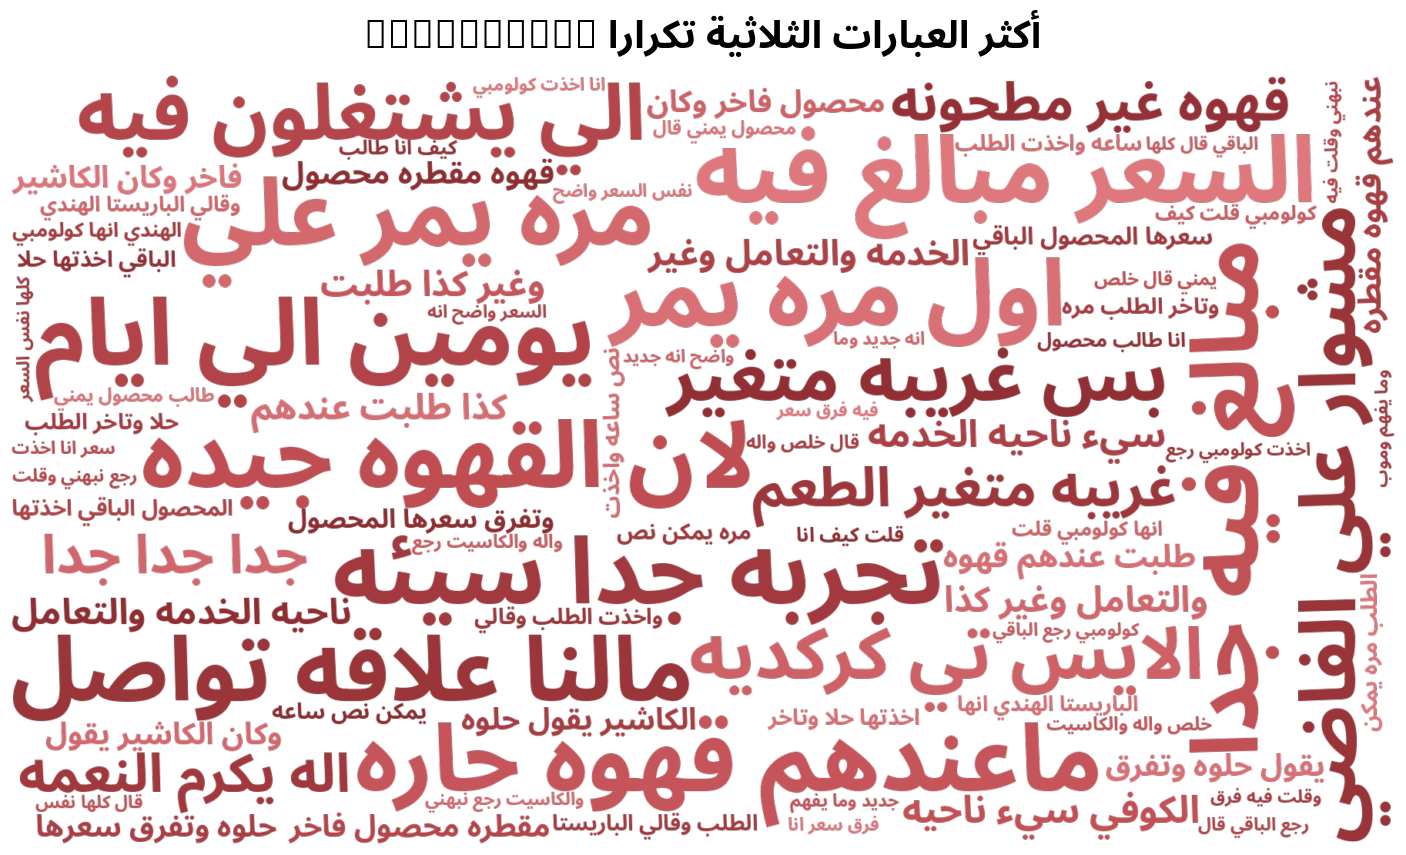

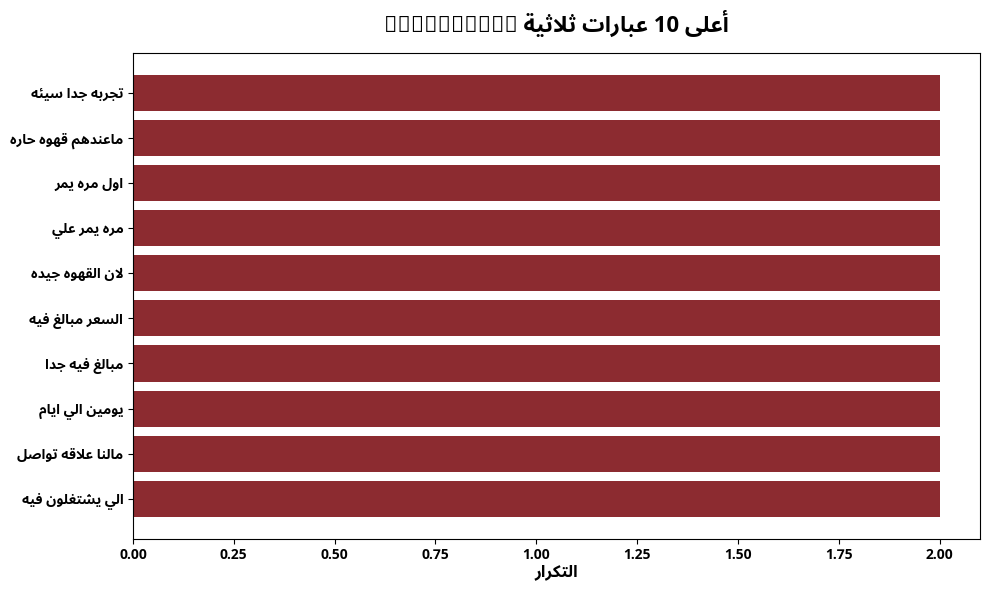


 Processing NEUTRAL reviews (78 texts)
   Generating unigrams...


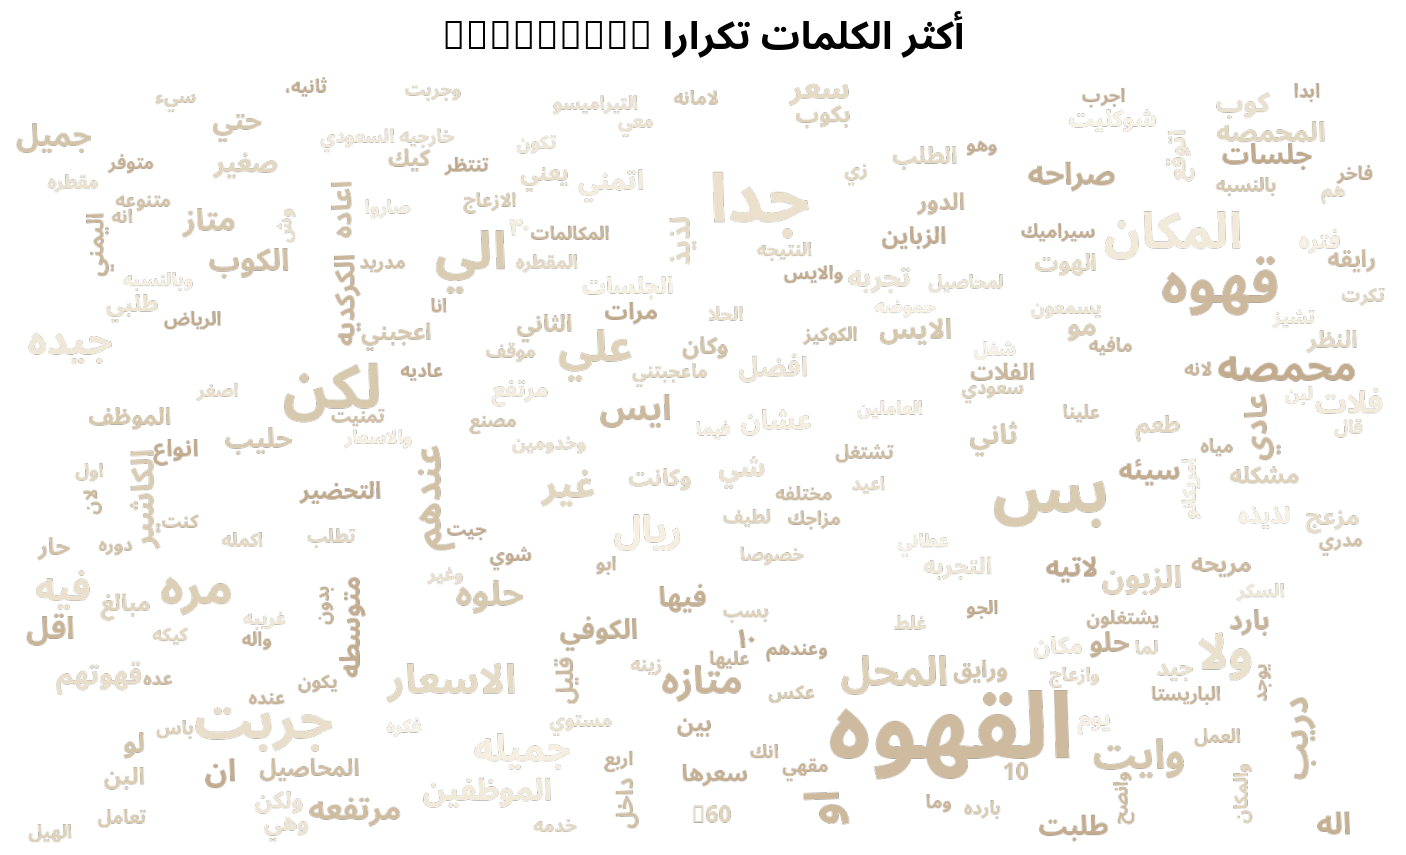

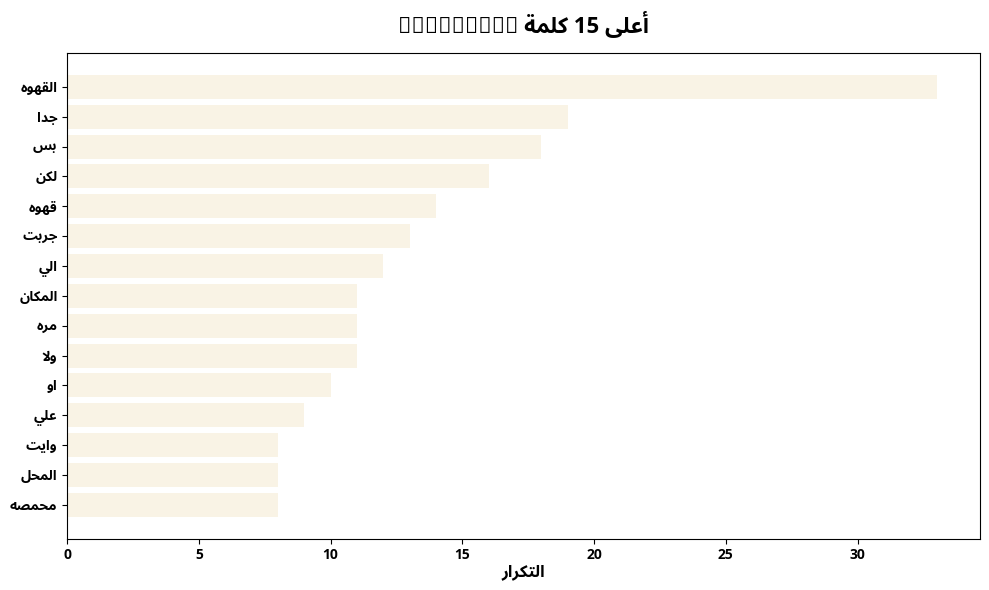

   Generating bigrams...


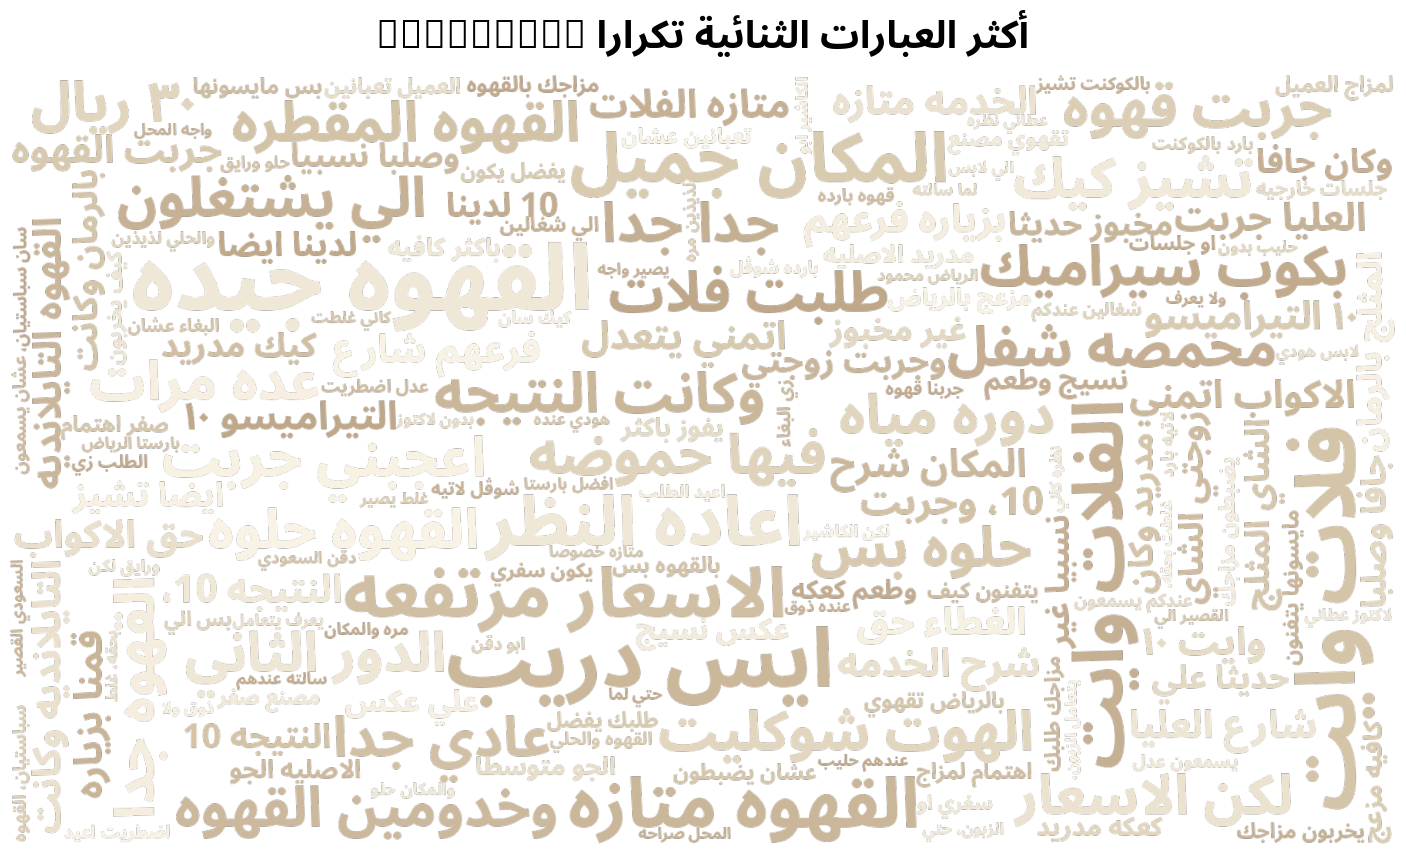

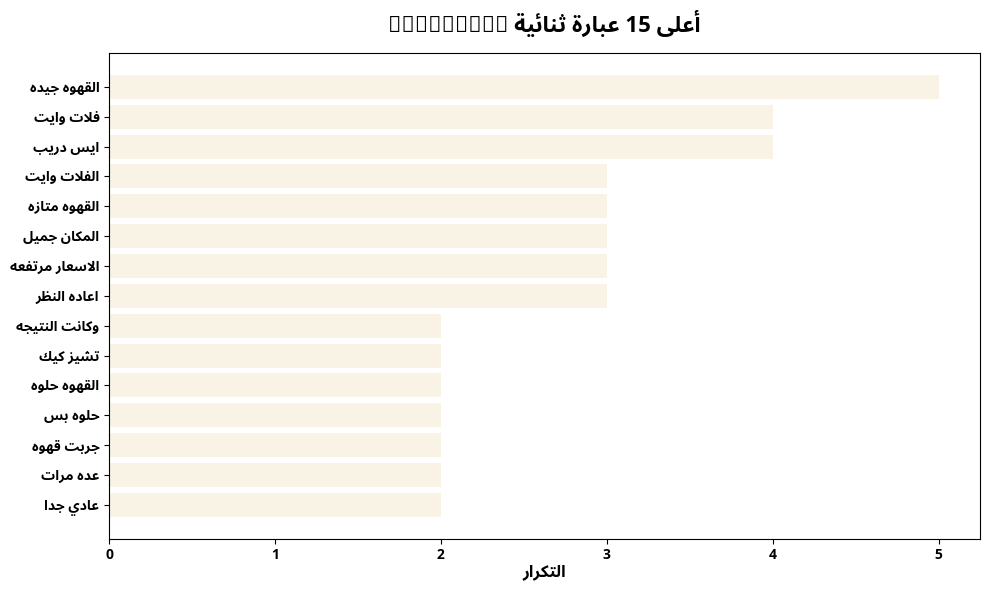

   Generating trigrams...


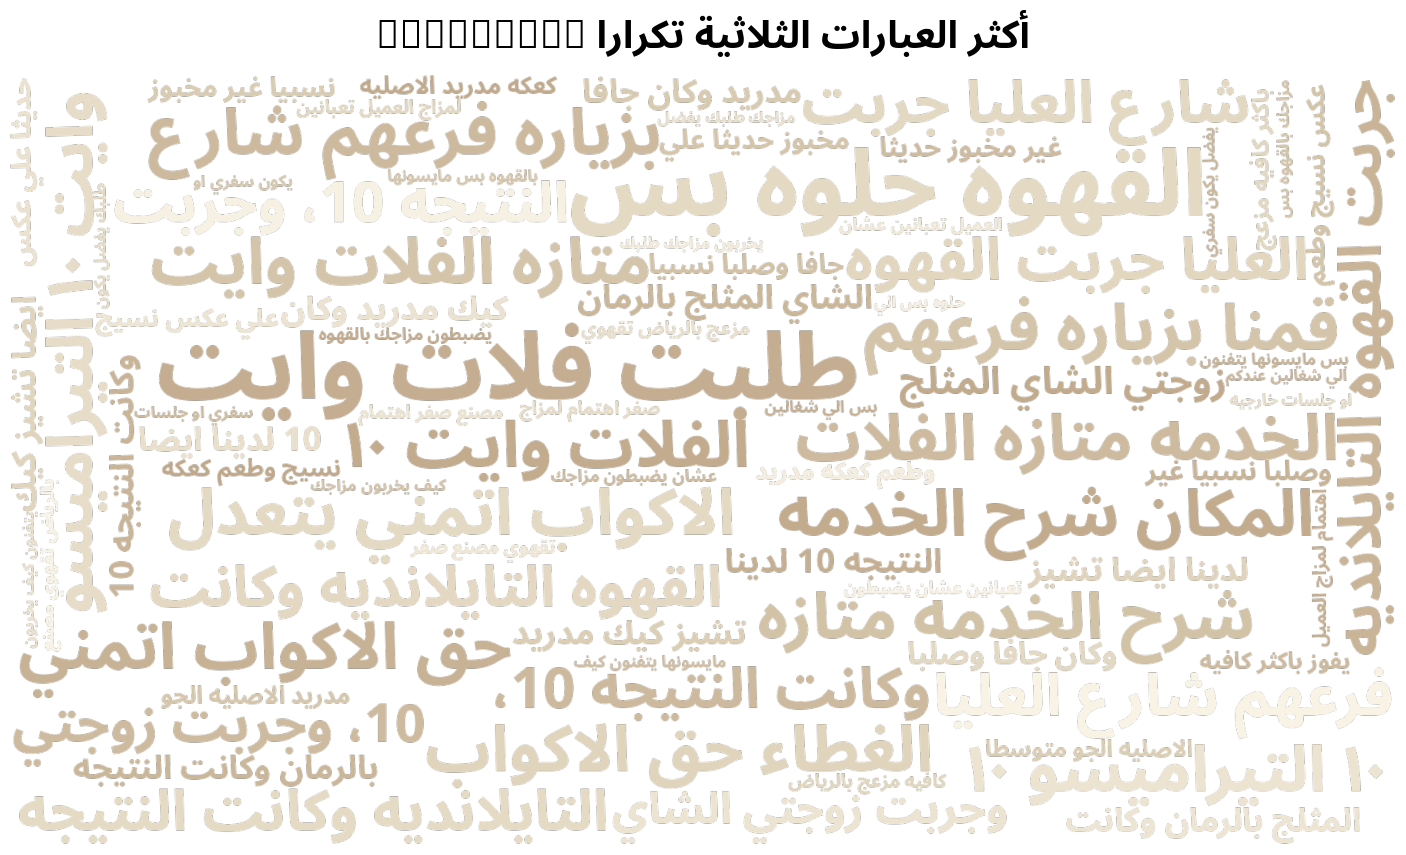

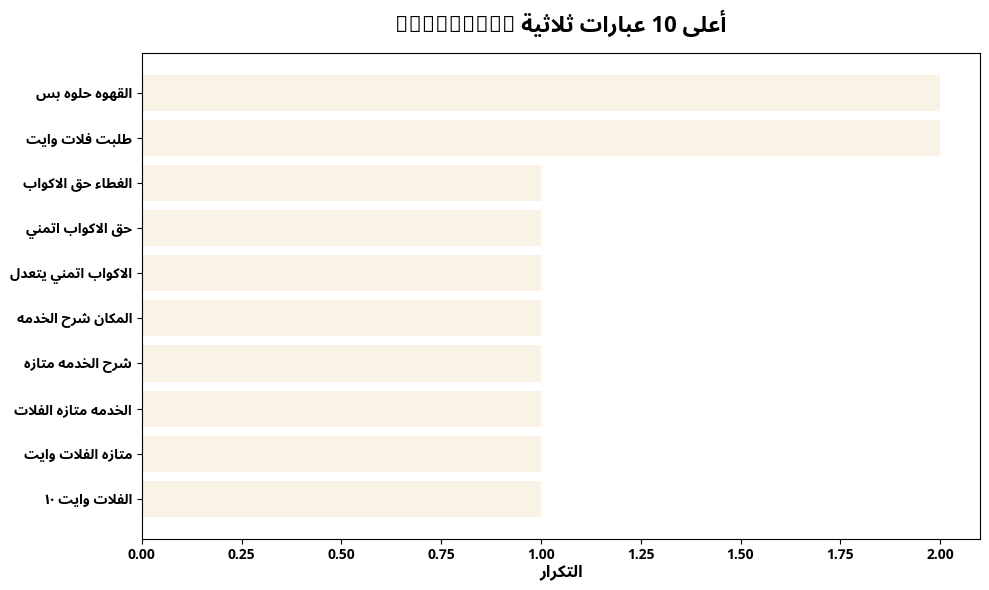


 All WordClouds and N-grams saved to outputs/visuals/


In [11]:
# ARABIC WORDCLOUD & N-GRAMS ANALYSIS

# FONT SETUP
print("\n Setting up Arabic font for visualizations...")

font_url = "https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansArabic/NotoSansArabic-Bold.ttf"
font_path = "/content/NotoSansArabic-Bold.ttf"

if not os.path.exists(font_path):
    try:
        !wget -q {font_url} -O {font_path}
        print(" Arabic font downloaded successfully.")
    except Exception as e:
        print(f" Font download failed: {e}")

if os.path.exists(font_path):
    print(" Arabic font ready for WordClouds.")
else:
    raise FileNotFoundError(" Arabic font not found! WordCloud will fail.")

def configure_matplotlib_font():
    """Configure matplotlib to use Arabic font"""
    import matplotlib.font_manager as fm
    if not os.path.exists(font_path):
        print(" Font file missing.")
        return
    if font_path not in [f.fname for f in fm.fontManager.ttflist]:
        fm.fontManager.addfont(font_path)
    arabic_font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [arabic_font_name] + plt.rcParams['font.sans-serif']
    print(f" Matplotlib configured with font: {arabic_font_name}")

configure_matplotlib_font()

# TEXT CLEANING & STOPWORDS

# Enhanced Arabic Stop Words
arabic_stopwords = set([
    'من','في','على','و','الذي','أو','إلى','أن','هو','هي','هذا','هذه',
    'كان','كانت','إن','مع','لم','عن','ما','كل','هناك','ذلك','كما','قد','لا',
    'يا', 'بها', 'به', 'بك', 'لك', 'لي', 'مما', 'أنا', 'أنت', 'أتى',
    'إذ', 'اذا', 'هؤلاء', 'مثل', 'لهم', 'لنا', 'كانوا', 'اليوم', 'أكثر',
    'التي', 'الذين', 'اللي', 'اللتي', 'عند', 'عندما', 'حيث', 'بعد', 'قبل'
])

def clean_arabic_text(text):
    """
    Enhanced Arabic text cleaning and normalization.
    Includes URL/Punctuation removal, Diacritics removal, and letter normalization.
    """
    if not isinstance(text, str):
        return ""

    text = text.strip()

    # Arabic normalization
    text = re.sub("[إأآا]", "ا", text)  # Standardize Alef variants
    text = re.sub("ى", "ي", text)       # Standardize Alef Maqsura
    text = re.sub("ؤ", "ئ", text)       # Standardize Hamza on Waw
    text = re.sub("ة", "ه", text)       # Standardize Ta Marbuta

    # Remove diacritics
    p_diacritics = re.compile(r'[\u064b-\u065e]')
    text = p_diacritics.sub('', text)

    # Remove elongation (e.g., آآآه -> آه)
    text = re.sub(r'(.)\1+', r'\1', text)

    # Remove noise (links, punctuation, extra spaces)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

def get_ngrams(texts, n=1):
    """Extract n-grams from texts with stopword filtering"""
    all_ngrams = []
    for t in texts:
        tokens = [tok for tok in t.split() if tok not in arabic_stopwords and len(tok) > 1]
        all_ngrams.extend(list(ngrams(tokens, n)))
    return Counter(all_ngrams)

# VISUALIZATION HELPERS

sentiment_colors = {
    "positive": ["#E3B34C", "#F5D88B", "#FFF3C2"],
    "negative": ["#8C2B30", "#C04E53", "#E07B80"],
    "neutral":  ["#F9F3E5", "#D9CBB0", "#BFA688"]
}

def gradient_color_func(color_list):
    """Create gradient color function for WordCloud"""
    cmap = LinearSegmentedColormap.from_list("custom_cmap", color_list)
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        np.random.seed(hash(word) % (2**32))
        return plt.cm.colors.rgb2hex(cmap(np.random.rand()))
    return color_func

def fix_arabic_display(text):
    """Fix Arabic text for proper RTL display"""
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

# PLOTTING FUNCTIONS

def generate_wordcloud(tokens, title, sentiment, save_path=None):
    """Generate and display WordCloud with Arabic text support"""
    if not tokens:
        print(f" No tokens to generate WordCloud for {sentiment}")
        return

    tokens_str = {" ".join(k) if isinstance(k, tuple) else k: v for k, v in tokens.items()}

    wc = WordCloud(
        width=1800,
        height=1000,
        background_color=None,
        mode="RGBA",
        font_path=font_path,
        max_words=250,
        collocations=False,
        color_func=gradient_color_func(sentiment_colors.get(sentiment.lower(), ["#000"])),
        min_font_size=20,
        max_font_size=120,
        relative_scaling=0.6,
        prefer_horizontal=0.9,
        font_step=1,
        regexp=r"[\u0600-\u06FF\w\s]+"
    ).generate_from_frequencies(tokens_str)

    plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    reshaped_title = fix_arabic_display(title)
    plt.title(reshaped_title, fontsize=28, fontweight='bold', pad=20)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

def plot_top_ngrams(counter, title, sentiment, top=15, save_path=None):
    """Plot top n-grams with Arabic text support"""
    if not counter:
        print(f" No n-grams to plot for {sentiment}")
        return

    items = counter.most_common(top)
    labels = [fix_arabic_display(" ".join(w) if isinstance(w, tuple) else w) for w, _ in items]
    counts = [c for _, c in items]

    plt.figure(figsize=(10, 6))
    plt.barh(labels[::-1], counts[::-1], color=sentiment_colors.get(sentiment.lower(), ["#777"])[0])

    reshaped_title = fix_arabic_display(title)
    plt.title(reshaped_title, fontsize=16, fontweight='bold', pad=15)
    plt.xlabel(fix_arabic_display("التكرار"), fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# GENERATE VISUALIZATIONS FOR EACH SENTIMENT

os.makedirs("outputs/visuals", exist_ok=True)

print("\n Applying enhanced Arabic text cleaning and normalization...")
df_clean["Review Text AR"] = df_clean["Review Text AR"].progress_apply(clean_arabic_text)

print("\n Generating WordClouds and N-grams analysis...")

for sentiment_key in ["positive", "negative", "neutral"]:
    df_sent = df_clean[df_clean["Sentiment"] == sentiment_key]
    texts = df_sent["Review Text AR"].dropna().tolist()

    if not texts:
        print(f" Skipping {sentiment_key.capitalize()}: No valid texts found.")
        continue

    print(f"\n{'='*60}")
    print(f" Processing {sentiment_key.upper()} reviews ({len(texts)} texts)")
    print(f"{'='*60}")

    Title_Sentiment = sentiment_key.capitalize()

    # 1. Unigrams (Single Words)
    print(f"   Generating unigrams...")
    unigram_counts = get_ngrams(texts, 1)
    if unigram_counts:
        generate_wordcloud(
            unigram_counts,
            f"أكثر الكلمات تكرارًا ({Title_Sentiment})",
            sentiment_key,
            f"outputs/visuals/wordcloud_unigrams_{sentiment_key}.png"
        )
        plot_top_ngrams(
            unigram_counts,
            f"أعلى 15 كلمة ({Title_Sentiment})",
            sentiment_key,
            save_path=f"outputs/visuals/top_unigrams_{sentiment_key}.png"
        )

    # 2. Bigrams (Two-word phrases)
    print(f"   Generating bigrams...")
    bigram_counts = get_ngrams(texts, 2)
    if bigram_counts:
        generate_wordcloud(
            bigram_counts,
            f"أكثر العبارات الثنائية تكرارًا ({Title_Sentiment})",
            sentiment_key,
            f"outputs/visuals/wordcloud_bigrams_{sentiment_key}.png"
        )
        plot_top_ngrams(
            bigram_counts,
            f"أعلى 15 عبارة ثنائية ({Title_Sentiment})",
            sentiment_key,
            save_path=f"outputs/visuals/top_bigrams_{sentiment_key}.png"
        )

    # 3. Trigrams (Three-word phrases)
    print(f"   Generating trigrams...")
    trigram_counts = get_ngrams(texts, 3)
    if len(trigram_counts) > 0:
        generate_wordcloud(
            trigram_counts,
            f"أكثر العبارات الثلاثية تكرارًا ({Title_Sentiment})",
            sentiment_key,
            f"outputs/visuals/wordcloud_trigrams_{sentiment_key}.png"
        )
        plot_top_ngrams(
            trigram_counts,
            f"أعلى 10 عبارات ثلاثية ({Title_Sentiment})",
            sentiment_key,
            top=10,
            save_path=f"outputs/visuals/top_trigrams_{sentiment_key}.png"
        )

print("\n All WordClouds and N-grams saved to outputs/visuals/")

**Time Series & Correlation Analysis**

This section explores temporal trends and relationships in the review dataset.

1. **Data Preparation**
- Drop rows with missing `Review Date`.
- Extract `YearMonth`, `Year`, `Month`, and `DayOfWeek` for temporal analysis.

2. **Sentiment Trend Over Time**
- Aggregate counts of each sentiment per month.
- Visualize using an interactive **Plotly line chart**.
- Color-coded: Positive (Yellow), Negative (Red), Neutral (Light Beige).
- Hover shows the number of reviews per month per sentiment.
- Saved as `outputs/sentiment_trend.html`.

3. **Sentiment vs Rating**
- Examine distribution of ratings for each sentiment.
- Visualized using **Plotly box plot**.
- Helps identify correlation between positive/negative reviews and higher/lower ratings.
- Saved as `outputs/sentiment_vs_rating.html`.

4. **Monthly Review Volume**
- Count total reviews per month.
- Visualized using an interactive **Plotly bar chart**.
- Saved as `outputs/monthly_volume.html`.

> All charts are interactive and saved in the `outputs/` folder for easy access and sharing.



In [12]:
# TIME SERIES AND CORRELATION ANALYSIS

print("\n" + "="*60)
print(" TIME SERIES & CORRELATION ANALYSIS")
print("="*60)

# Prepare time series data
df_time = df_clean.dropna(subset=["Review Date"]).copy()

if len(df_time) == 0:
    print(" No reviews with valid dates found. Skipping time series analysis.")
else:
    # Extract temporal features
    df_time["YearMonth"] = df_time["Review Date"].dt.to_period("M").astype(str)
    df_time["Year"] = df_time["Review Date"].dt.year
    df_time["Month"] = df_time["Review Date"].dt.month
    df_time["DayOfWeek"] = df_time["Review Date"].dt.day_name()

    # Sentiment trend over time
    sentiment_trend = df_time.groupby(["YearMonth", "Sentiment"]).size().reset_index(name="Count")
    sentiment_trend = sentiment_trend.sort_values("YearMonth")

    # Plotly colors
    plotly_sentiment_colors = {
        "positive": "#E3B34C",
        "negative": "#8C2B30",
        "neutral": "#F9F3E5"
    }

    # 1. Line chart: Sentiment trend over time
    print("\n Generating sentiment trend over time...")
    fig_line = px.line(
        sentiment_trend,
        x="YearMonth",
        y="Count",
        color="Sentiment",
        color_discrete_map=plotly_sentiment_colors,
        title=" Sentiment Trend Over Time",
        markers=True
    )
    fig_line.update_layout(
        xaxis_title="Month",
        yaxis_title="Number of Reviews",
        xaxis_tickangle=-45,
        template="plotly_white",
        hovermode='x unified'
    )
    fig_line.write_html("outputs/sentiment_trend.html")
    fig_line.show()

    # 2. Box plot: Sentiment vs Rating
    print("\n Generating sentiment vs rating distribution...")
    fig_box = px.box(
        df_clean.dropna(subset=['Sentiment']),
        x="Sentiment",
        y="Rating",
        color="Sentiment",
        color_discrete_map=plotly_sentiment_colors,
        title=" Relationship Between Sentiment and Rating",
        category_orders={"Sentiment": ["positive", "neutral", "negative"]}
    )
    fig_box.update_layout(
        xaxis_title="Sentiment",
        yaxis_title="Rating",
        template="plotly_white",
        showlegend=False
    )
    fig_box.write_html("outputs/sentiment_vs_rating.html")
    fig_box.show()

    # 3. Monthly review volume
    print("\n Generating monthly review volume...")
    monthly_volume = df_time.groupby("YearMonth").size().reset_index(name="Count")
    monthly_volume = monthly_volume.sort_values("YearMonth")

    fig_volume = px.bar(
        monthly_volume,
        x="YearMonth",
        y="Count",
        title=" Monthly Review Volume",
        color="Count",
        color_continuous_scale="YlOrRd"
    )
    fig_volume.update_layout(
        xaxis_title="Month",
        yaxis_title="Number of Reviews",
        xaxis_tickangle=-45,
        template="plotly_white"
    )
    fig_volume.write_html("outputs/monthly_volume.html")
    fig_volume.show()

    print("\n All interactive charts saved to outputs/")


 TIME SERIES & CORRELATION ANALYSIS

 Generating sentiment trend over time...



 Generating sentiment vs rating distribution...



 Generating monthly review volume...



 All interactive charts saved to outputs/


**Analytical Summary & Export Function for Arabic Reviews**

This Python function generates a **comprehensive analytical summary** of customer reviews for "Shovel Roastery - Yasmin Branch". It is designed to provide **insights on sentiment distribution, average ratings, temporal trends, top repeated words, and overall trends**, with proper handling of **Arabic text display**.

**Key Features:**

1. **Sentiment Analysis Overview**  
   - Counts of positive, neutral, and negative reviews  
   - Percentage representation for easy interpretation

2. **Rating Statistics**  
   - Average and median ratings of all reviews

3. **Temporal Insights**  
   - Analysis of review period, duration, and reviews per day

4. **Top Words Analysis**  
   - Identification of the most frequently used words in Arabic reviews  
   - Proper reshaping and right-to-left (RTL) display support

5. **Trend Determination**  
   - Overall sentiment trend with an emoji indicator (🟢, 🟡, 🔴, ⚖️)

6. **Recommendations**  
   - Automatic suggestions based on sentiment percentages to guide improvement or highlight strengths

7. **Export Functionality**  
   - Saves the analyzed dataset as CSV  
   - Writes the summary and recommendations to a text file

This function ensures a **clear, well-structured, and visually correct summary** suitable for reports, dashboards, or management insights.

In [13]:
# FINAL SUMMARY & EXPORT FUNCTION

# Arabic stopwords
arabic_stopwords = set([
    'من','في','على','و','الذي','أو','إلى','أن','هو','هي','هذا','هذه',
    'كان','كانت','إن','مع','لم','عن','ما','كل','هناك','ذلك','كما','قد','لا',
    'يا', 'بها', 'به', 'بك', 'لك', 'لي', 'مما', 'أنا', 'أنت', 'أتى',
    'إذ', 'اذا', 'هؤلاء', 'مثل', 'لهم', 'لنا', 'كانوا', 'اليوم', 'أكثر'
])

# Function to fix Arabic text for proper display
def fix_arabic(text):
    """Reshape Arabic text and apply RTL correction for proper display."""
    if not text:
        return ""
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

# Improved Analytical Summary with Recommendations
def summarize_results(df):
    """Generates a comprehensive summary of sentiment analysis with top words in correct Arabic display and recommendations."""
    df_summary = df.copy().dropna(subset=["Sentiment"])
    total = len(df_summary)

    if total == 0:
        print("لا توجد بيانات للمراجعات بعد تحليل المشاعر.")
        return

    # Count each sentiment
    pos = (df_summary["Sentiment"] == "positive").sum()
    neg = (df_summary["Sentiment"] == "negative").sum()
    neu = (df_summary["Sentiment"] == "neutral").sum()
    pos_pct = pos / total * 100
    neg_pct = neg / total * 100
    neu_pct = neu / total * 100

    # Rating statistics
    avg_rating = df_summary["Rating"].mean()
    median_rating = df_summary["Rating"].median()

    # Temporal insights
    df_with_dates = df_summary.dropna(subset=["Review Date"])
    if len(df_with_dates) > 0:
        earliest = df_with_dates["Review Date"].min()
        latest = df_with_dates["Review Date"].max()
        duration = (latest - earliest).days
        reviews_per_day = total / max(duration, 1)
    else:
        earliest = latest = None
        duration = 0
        reviews_per_day = 0

    # Unique reviewers
    unique_reviewers = df_summary["Author Name"].nunique()

    # Top words analysis (with proper Arabic display)
    tokens = [t for t in word_tokenize(" ".join(df_summary["Review Text AR"].dropna()))
              if t.isalpha() and t not in arabic_stopwords and len(t) > 1]
    top_3_words = Counter(tokens).most_common(3)

    # Determine trend
    if pos_pct > 60:
        trend, trend_emoji = "إيجابي بشكل واضح", "🟢"
    elif neg_pct > 40:
        trend, trend_emoji = "سلبي بحاجة للانتباه", "🔴"
    elif neu_pct > 50:
        trend, trend_emoji = "محايد - مساحة للتحسين", "🟡"
    else:
        trend, trend_emoji = "متوازن بين المشاعر المختلفة", "⚖️"

    # Format summary
    summary = f"""
{'='*70}
#  ملخص تحليلي شامل - محمصة شفل (فرع الياسمين)
{'='*70}

## 📊 إحصائيات عامة
- **إجمالي المراجعات المحللة:** {total:,}
- **عدد المراجعين الفريدين:** {unique_reviewers:,}
- **متوسط التقييم:** {avg_rating:.2f}/5 ⭐
- **التقييم الوسيط:** {median_rating:.1f}/5

## توزيع المشاعر
- 🟡 إيجابية: {pos:,} مراجعة ({pos_pct:.1f}%)
- ⚪ محايدة: {neu:,} مراجعة ({neu_pct:.1f}%)
- 🔴 سلبية: {neg:,} مراجعة ({neg_pct:.1f}%)

## التحليل الزمني
"""
    if earliest and latest:
        summary += f"- **الفترة الزمنية:** {earliest.strftime('%Y-%m-%d')} إلى {latest.strftime('%Y-%m-%d')}\n"
        summary += f"- **المدة:** {duration:,} يوم\n- **معدل المراجعات:** {reviews_per_day:.1f} مراجعة/يوم\n"
    else:
        summary += "- **التحليل الزمني:** غير متوفر (لا توجد تواريخ صحيحة)\n"

    summary += "\n## الكلمات الأكثر تكراراً\n"
    if top_3_words:
        for i, (word, count) in enumerate(top_3_words, 1):
            # استخدام النص الأصلي بدون fix_arabic للملفات النصية
            summary += f"{i}. **{word}** ({count:,} مرة)\n"
    else:
        summary += "- لا توجد بيانات كافية\n"

    summary += f"\n## {trend_emoji} الاتجاه العام\n**{trend}**\n"

    # Recommendations based on sentiment percentages
    summary += "\n## 💡 التوصيات\n"
    if pos_pct > 70:
        summary += "- الأداء ممتاز! حافظ على المستوى واستمر في تطوير نقاط القوة.\n"
    elif pos_pct > 50:
        summary += "- الأداء جيد، لكن هناك مجال للتحسين في بعض الجوانب.\n"

    if neg_pct > 20:
        summary += f"- نسبة المراجعات السلبية ({neg_pct:.1f}%) تحتاج إلى اهتمام:\n"
        summary += "  - راجع المراجعات السلبية لتحديد نقاط التحسين.\n"
        summary += "  - ركز على معالجة الشكاوى المتكررة.\n"

    if neu_pct > 30:
        summary += f"- نسبة المراجعات المحايدة ({neu_pct:.1f}%) عالية:\n"
        summary += "  - حاول تحويل التجربة المحايدة إلى إيجابية.\n"
        summary += "  - أضف عناصر تميز للخدمة.\n"

    summary += f"\n{'='*70}\n"

    # Print summary
    print(summary)

    # Save summary and CSV
    df_summary.to_csv("outputs/Shovel_roastery_yasmin_reviews_analyzed.csv", index=False, encoding="utf-8-sig")
    with open("outputs/analysis_summary.txt", "w", encoding="utf-8") as f:
        f.write(summary)
    print("Summary, recommendations, and final CSV saved successfully in 'outputs/' folder.")

# Execute summary
summarize_results(df_clean)


#  ملخص تحليلي شامل - محمصة شفل (فرع الياسمين)

## 📊 إحصائيات عامة
- **إجمالي المراجعات المحللة:** 1,317
- **عدد المراجعين الفريدين:** 1,271
- **متوسط التقييم:** 4.42/5 ⭐
- **التقييم الوسيط:** 5.0/5

## توزيع المشاعر
- 🟡 إيجابية: 1,111 مراجعة (84.4%)
- ⚪ محايدة: 78 مراجعة (5.9%)
- 🔴 سلبية: 128 مراجعة (9.7%)

## التحليل الزمني
- **الفترة الزمنية:** 2021-01-25 إلى 2025-10-17
- **المدة:** 1,725 يوم
- **معدل المراجعات:** 0.8 مراجعة/يوم

## الكلمات الأكثر تكراراً
1. **جدا** (415 مرة)
2. **القهوه** (394 مرة)
3. **قهوه** (319 مرة)

## 🟢 الاتجاه العام
**إيجابي بشكل واضح**

## 💡 التوصيات
- الأداء ممتاز! حافظ على المستوى واستمر في تطوير نقاط القوة.


Summary, recommendations, and final CSV saved successfully in 'outputs/' folder.
